In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(42)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import floor

from utils import concordance_index_censored_scorer,concordance_index_ipcw_scorer,integrated_brier_scorer,cumulative_dynamic_auc_scorer
from utils import log_rank_test,log_rank_test_scorer
from utils import reduce_T_max,reduce_uncensored

from sklearn.model_selection import KFold

import json
import os

from sksurv.nonparametric import kaplan_meier_estimator

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize,LogNorm
from matplotlib.cm import ScalarMappable

In [2]:
NAME = "veteran"
NAME_PLOT = "Veteran's Lung Cancer"

plt.rcParams.update({'font.size': 20})

from sksurv.datasets import load_veterans_lung_cancer
df,y = load_veterans_lung_cancer()
df["Status"] = y["Status"]
df["Survival_in_days"] = y["Survival_in_days"]

timeline_resolution = 200

T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
#red_rates = [1.0,0.8,0.6,0.4,0.2]
#red_rates = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

from itertools import product
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

# Preprocessing

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sksurv.column import encode_categorical

In [4]:
df_original = df.copy()

In [5]:
df.head()

Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0

In [6]:
df = encode_categorical(df)

S:\workspace\gerincmet\venv\lib\site-packages\sksurv\column.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_encode = {nam for nam, s in table.iteritems() if _is_categorical_or_object(s)}
S:\workspace\gerincmet\venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


In [7]:
cont_features = ["Age_in_years","Karnofsky_score","Months_from_Diagnosis"]

In [8]:
scaler = MinMaxScaler()
df[cont_features] = scaler.fit_transform(df[cont_features])

In [9]:
time_scaler = MinMaxScaler()
y["Survival_in_days"] = time_scaler.fit_transform(y["Survival_in_days"] .reshape(-1, 1)).reshape(-1)

In [10]:
df.head()

Age_in_years  Celltype=large  Celltype=smallcell  Celltype=squamous  \
0      0.744681             0.0                 0.0                1.0   
1      0.638298             0.0                 0.0                1.0   
2      0.085106             0.0                 0.0                1.0   
3      0.617021             0.0                 0.0                1.0   
4      0.659574             0.0                 0.0                1.0   

   Karnofsky_score  Months_from_Diagnosis  Prior_therapy=yes  Treatment=test  \
0         0.561798               0.069767                0.0             0.0   
1         0.674157               0.046512                1.0             0.0   
2         0.561798               0.023256                0.0             0.0   
3         0.561798               0.093023                1.0             0.0   
4         0.674157               0.116279                1.0             0.0   

   Status  Survival_in_days  
0    True              72.0  
1    True             411.0  
2    True             228.0  
3    True             126.0  
4    True             118.0

In [11]:
# Divide the data
X = df.drop(["Survival_in_days","Status"],axis = 1)
x_size = len(X.columns)
X = np.float32(X.to_numpy())
t = np.float32(y["Survival_in_days"])
delta = y["Status"].astype(np.float32)
y = np.stack([t,delta],axis = 1)

In [12]:
# Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

# Create a timeline for evaluation
t_max = min([t_max,max(y_test[:,0])])
t_min = max([t_min,min(y_test[:,0])])
timeline = np.linspace(t_min,t_max,timeline_resolution,endpoint=False).astype(np.float32)

# Exploration

In [13]:
# Dataset statistics

properties = {"Dataset": f"{NAME_PLOT}",
              "Num. of Patients": len(df_original),
              "Num. of Features": len(df_original.columns)-2,
              "Num. of Numeric Features": len(cont_features),
              "Num. of Categorical Features": len(df_original.columns)-2-len(cont_features),
              "Mean Survival": round(np.mean(df_original.Survival_in_days),2),
              "Min. Survival": round(min(df_original.Survival_in_days),2),
              "Max. Survival": round(max(df_original.Survival_in_days),2),
              "Num. of Censored": len(df_original[df_original["Status"] == False]),
              "Censored %": round(len(df_original[df_original["Status"] == False])/len(df_original)*100,2),
              "Censored Mean Survival": round(np.mean(df_original.Survival_in_days[df_original["Status"] == False]),2),
              "Censored Min. Survival": round(min(df_original.Survival_in_days[df_original["Status"] == False]),2),
              "Censored Max. Survival": round(max(df_original.Survival_in_days[df_original["Status"] == False]),2),
              "Num. of Uncensored": len(df_original[df_original["Status"] == True]),
              "Uncensored %": round(len(df_original[df_original["Status"] == True])/len(df_original)*100,2),
              "Uncensored Mean Survival": round(np.mean(df_original.Survival_in_days[df_original["Status"] == True]),2),
              "Uncensored Min. Survival": round(min(df_original.Survival_in_days[df_original["Status"] == True]),2),
              "Uncensored Max. Survival": round(max(df_original.Survival_in_days[df_original["Status"] == True]),2)}

_ = [print(key,':',value) for key, value in properties.items()]

Dataset : Veteran's Lung Cancer
Num. of Patients : 137
Num. of Features : 6
Num. of Numeric Features : 3
Num. of Categorical Features : 3
Mean Survival : 121.63
Min. Survival : 1.0
Max. Survival : 999.0
Num. of Censored : 9
Censored % : 6.57
Censored Mean Survival : 114.56
Censored Min. Survival : 25.0
Censored Max. Survival : 231.0
Num. of Uncensored : 128
Uncensored % : 93.43
Uncensored Mean Survival : 122.12
Uncensored Min. Survival : 1.0
Uncensored Max. Survival : 999.0


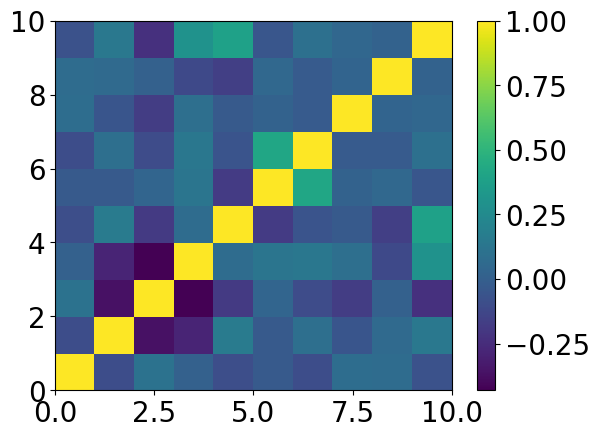

In [350]:
plt.pcolor(df.corr())
plt.colorbar()

In [353]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox_test_df = pd.DataFrame(np.append(np.vstack([y_train,y_test]),np.hstack([np.zeros(len(y_train)).T,np.ones(len(y_test))]).reshape(-1,1),axis=1))

cph = CoxPHFitter()
cph.fit(df = cox_test_df,
        duration_col = 0,
        event_col = 1)

print(cph.summary)

#cph.check_assumptions(cox_test_df,
#                      show_plots=True,
#                      p_value_threshold=0.7)

print(cph.log_likelihood_ratio_test())

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.213706   1.238258  0.198634        -0.17561        0.603022   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.838945             1.827633     0.0  1.075876   

                  p  -log2(p)  
covariate                      
2          0.281983   1.82632  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.13 0.29      1.80


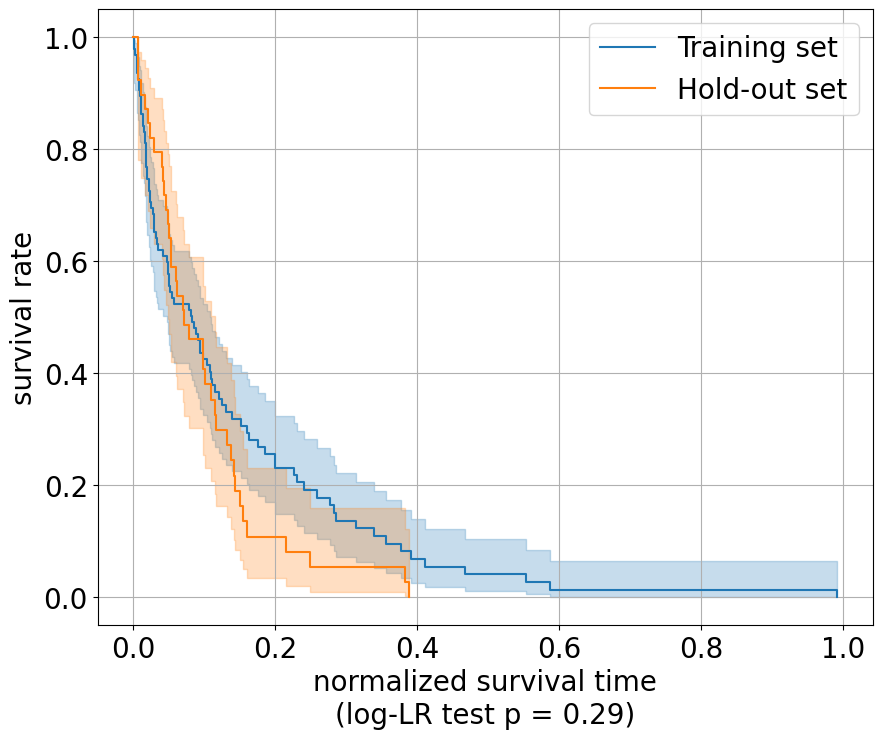

In [354]:
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

plt.figure(figsize=(10,8))

kmf1 = KaplanMeierFitter(label="Training set")
kmf1.fit(y_train[:,0], y_train[:,1])
kmf1.plot()

kmf2 = KaplanMeierFitter(label="Hold-out set")
kmf2.fit(y_test[:,0], y_test[:,1])
kmf2.plot()

#plt.title("KM estimator of the training and hold-out sets")
plt.xlabel(f"normalized survival time\n(log-LR test p = {round(cph.log_likelihood_ratio_test().p_value,2)})")
plt.ylabel("survival rate")
plt.grid()
plt.show()

## Testing the 5Fold Cross Validation Data

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.029835   0.970606  0.261891       -0.543131        0.483461   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z       p  \
covariate                                                                       
2                     0.580926             1.621678     0.0 -0.113921  0.9093   

           -log2(p)  
covariate            
2          0.137171  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.01 0.91      0.14


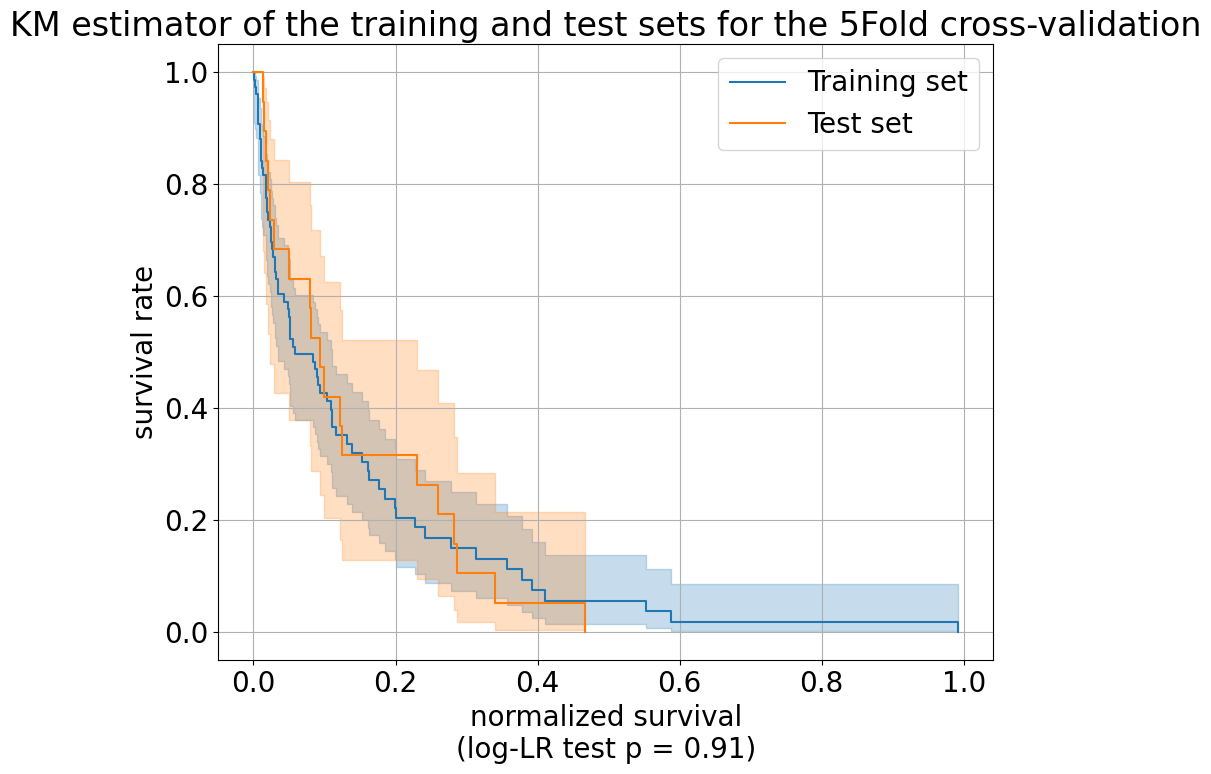

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.135175   0.873563  0.286834        -0.69736         0.42701   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.497898             1.532668     0.0 -0.471264   

                  p  -log2(p)  
covariate                      
2          0.637452  0.649612  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.23 0.63      0.66


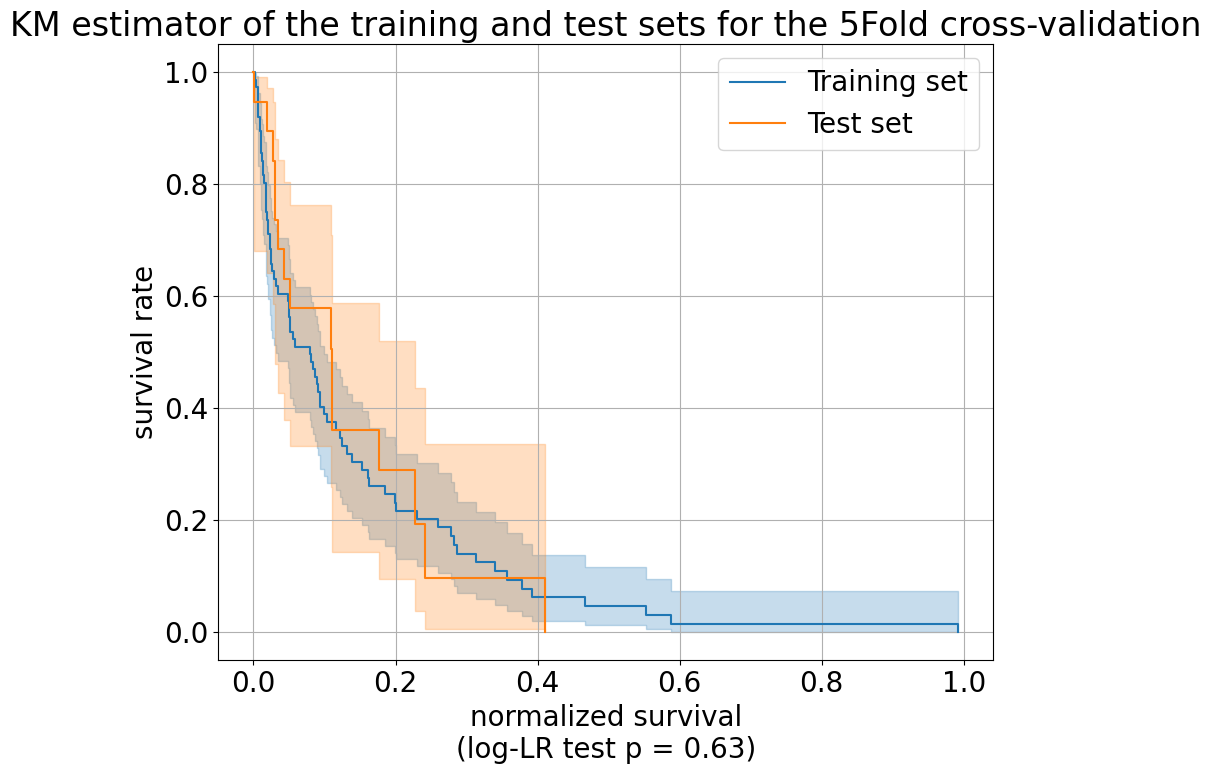

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.151861   1.163999  0.267194       -0.371828        0.675551   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.689473             1.965116     0.0  0.568357   

                  p  -log2(p)  
covariate                      
2          0.569793  0.811491  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.31 0.58      0.80


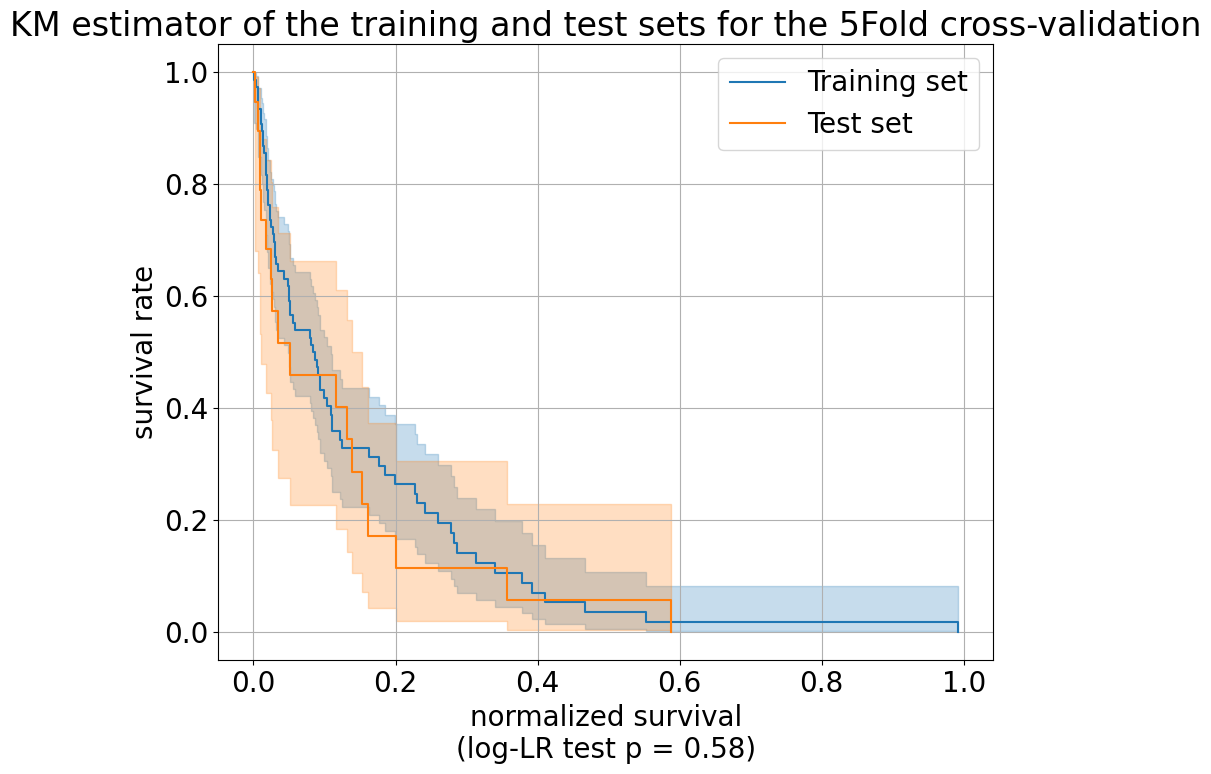

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.222141   0.800802  0.278914       -0.768802         0.32452   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z        p  \
covariate                                                                       
2                     0.463568             1.383366     0.0 -0.79645  0.42577   

           -log2(p)  
covariate            
2          1.231853  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.66 0.42      1.27


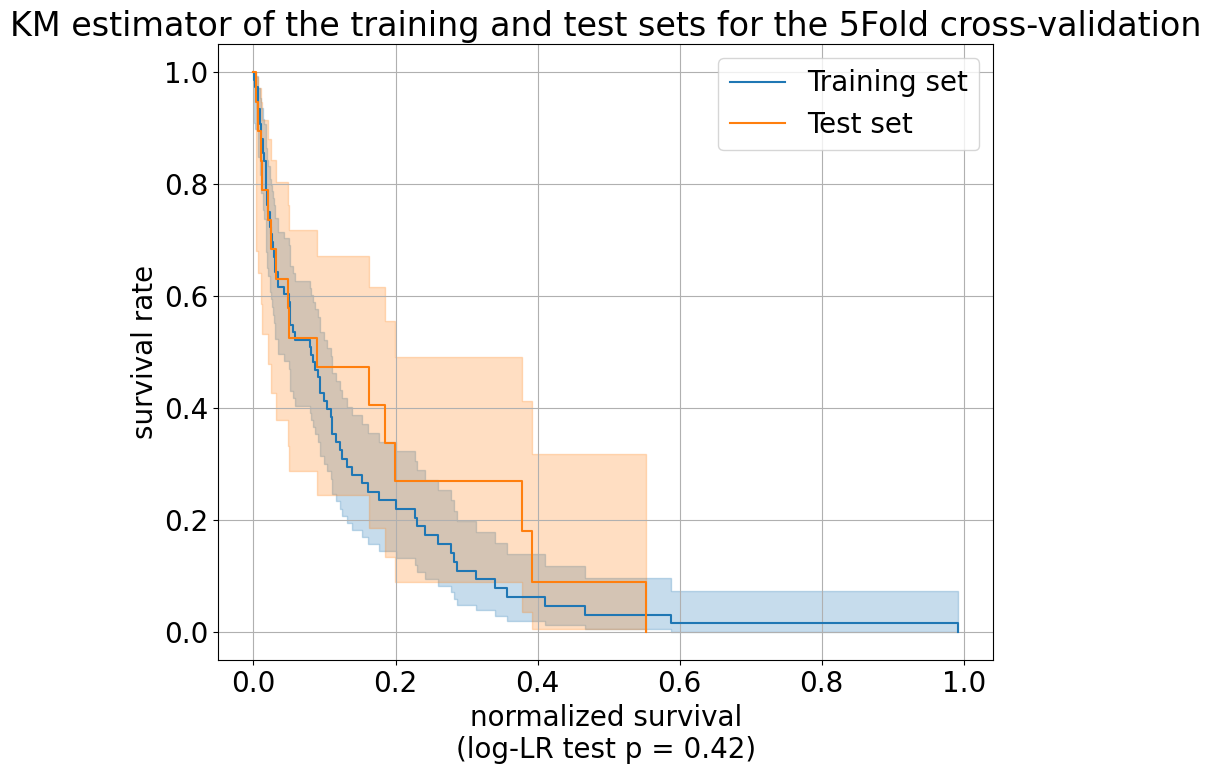

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.244168   1.276559  0.268016       -0.281133         0.76947   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.754928             2.158622     0.0  0.911022   

                  p  -log2(p)  
covariate                      
2          0.362284  1.464807  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.79 0.37      1.42


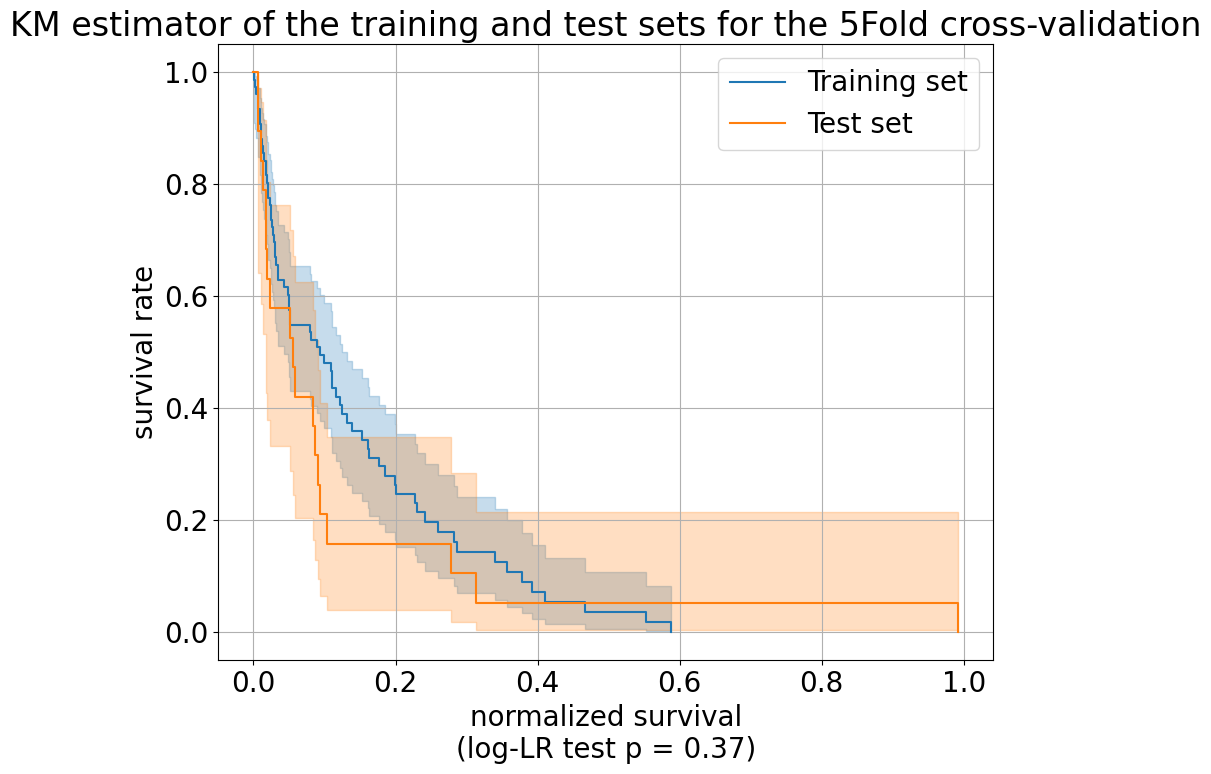

In [352]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, test_index in kf.split(y_train):
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    
    #COX analysis
    
    cox_test_df = pd.DataFrame(np.append(np.vstack([y_train_train,y_train_test]),np.hstack([np.zeros(len(y_train_train)).T,np.ones(len(y_train_test))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    print(cph.summary)

    #cph.check_assumptions(cox_test_df,show_plots=True,p_value_threshold=0.7)
    #plt.show()

    print(cph.log_likelihood_ratio_test())
    p_val = round(cph.log_likelihood_ratio_test().p_value,2)
    
    # KM Plot
    plt.figure(figsize=(10,8))
    kmf1 = KaplanMeierFitter(label="Training set")
    kmf1.fit(y_train_train[:,0], y_train_train[:,1])
    kmf1.plot()
    kmf2 = KaplanMeierFitter(label="Test set")
    kmf2.fit(y_train_test[:,0], y_train_test[:,1])
    kmf2.plot()
    plt.title("KM estimator of the training and test sets for the 5Fold cross-validation")
    plt.xlabel(f"normalized survival\n(log-LR test p = {p_val})")
    plt.ylabel("survival rate")
    plt.grid()
    plt.show()

# Censoring Sensitivity Analysis

In [18]:
# Dictionary where all the results can be saved
results_table = {"Model":[],
                 "Optimized_LogRank":[],
                 "T_max":[],
                 "Uncensored_Reduction":[],
                 "5Fold":{"HarrelC":{"mean":[],
                                     "std":[]},
                          "UnoC":{"mean":[],
                                  "std":[]},
                          "iBrier":{"mean":[],
                                    "std":[]},
                          "AUROC":{"mean":[],
                                   "std":[]},
                          "LogRank":{"mean":[],
                                     "std":[]}},
                 "Hold-out":{"HarrelC":[],
                             "UnoC":[],
                             "iBrier":[],
                             "AUROC":[],
                             "LogRank":[]},
                 "Timeline":[],
                 "Overall_Survival_Function":[]}

with open(f"Logs/{NAME}_results.json", "w") as write_file:
        json.dump(results_table, write_file)

## MDN Model

### Shared Parameters

In [19]:
from model import MDN
from utils import NLLLoss, CensoredNLLLoss, AlternativeNLLLoss
from csa import MDNCensoringSensitivityAnalysis

# Fixed
num_epochs = 400
batch_size = 16
input_shape = x_size
learning_rate = 1e-3

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


### Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 64
mixture_components = 3
use_sparse_layer = False
use_sparse_loss = False#Default
lmbd = 1e-4 #Default
use_batchnorm = True
use_dropout = True
dropout = 0.6229041098452568
mlp_size_1 = 0
mlp_size_2 = 2
mlp_size_3 = 0
kernel = "Exponential"
loss_name = NLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = True

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 256
mixture_components = 2
use_sparse_layer = True
use_sparse_loss = False
lmbd = 1e-4 #Default
use_batchnorm = True
use_dropout = False
dropout = 0.0 #Default
mlp_size_1 = 0
mlp_size_2 = 2
mlp_size_3 = 0
kernel = "Exponential"
loss_name = NLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = False

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Compare LogRank vs. No LogRank

In [355]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

In [356]:
for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == True) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_lr = np.array(results_table["Timeline"][i])
        osf_lr = np.array(results_table["Overall_Survival_Function"][i])

for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == False) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_nlr = np.array(results_table["Timeline"][i])
        osf_nlr = np.array(results_table["Overall_Survival_Function"][i])

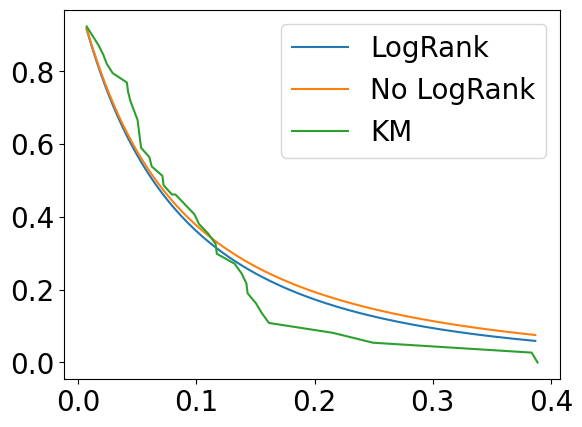

In [357]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(tl_lr, osf_lr, label = "LogRank")
plt.plot(tl_nlr, osf_nlr, label = "No LogRank")
plt.plot(km_timeline,km_prob_survival, label = "KM")
plt.legend()
plt.show()

## Other Models

In [25]:
from csa import MLCensoringSensitivityAnalysis

### CPH

In [26]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 2.292208483223857
ties = "efron"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 2.323999618444634
ties = "efron"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Tree

In [29]:
from sksurv.tree import SurvivalTree

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "random"
min_samples_split = 0.2634327795456142
min_samples_leaf = 0.0010397355641569754
min_weight_fraction_leaf = 0.06902031599129063
max_features = 0.5894070081890616
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "random"
min_samples_split = 0.26969799342025624
min_samples_leaf = 0.03400433689700358
min_weight_fraction_leaf = 0.04699760321144737
max_features = 0.6061175836251546
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Forest

In [32]:
from sksurv.ensemble import RandomSurvivalForest

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 528
min_samples_split = 0.2785372539864237
min_samples_leaf = 0.030808333109961134
min_weight_fraction_leaf = 0.04090745074272355
max_features = 0.7038678988047188
bootstrap = False
max_samples = 0.6183698914942392
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 100
min_samples_split = 0.1823316131264906
min_samples_leaf = 0.050091665904561135
min_weight_fraction_leaf = 0.023184957262683298
max_features = 0.6029199291777201
bootstrap = False
max_samples = 0.9086856608815692
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Boosting

In [35]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.004645967017840466
n_estimators=134
criterion="friedman_mse"
min_samples_split=4
min_samples_leaf=1
min_weight_fraction_leaf=0.05159598866050061
min_impurity_decrease=0.3211246858128828
max_features=0.9800160158982418
subsample=0.7618208024854627
dropout_rate=0.36976872325477317
ccp_alpha=0.002347135190183855
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.0042641785443198865
n_estimators=213
criterion="friedman_mse"
min_samples_split=2
min_samples_leaf=2
min_weight_fraction_leaf=0.07044458900638266
min_impurity_decrease=0.34657322016898084
max_features=0.9493715847660741
subsample=0.8064275977878402
dropout_rate=0.45823670487531626
ccp_alpha=0.005126301893450966
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

# Results

In [13]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

## 5-Fold

In [101]:
# 5FOLD

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_5fold  = {"Model":[],
                       "c-index $\\uparrow$":[],
                       "iBrier $\\downarrow$":[],
                       "AUROC $\\uparrow$":[],
                       "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_5fold["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_5fold["c-index $\\uparrow$"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["iBrier $\\downarrow$"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["AUROC $\\uparrow$"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["LogRank $\\uparrow$"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            
main_results_5fold = pd.DataFrame.from_dict(main_results_5fold)

In [102]:
main_results_5fold

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$  0.7064$\pm$0.0446   
1                                CoxPH   0.7064$\pm$0.0446   
2          SurvivalTree $^{^{LogRank}}$  0.7049$\pm$0.0290   
3                         SurvivalTree   0.7049$\pm$0.0290   
4  RandomSurvivalForest $^{^{LogRank}}$  0.7411$\pm$0.0706   
5                 RandomSurvivalForest   0.7206$\pm$0.0649   
6      GradientBoosting $^{^{LogRank}}$  0.7392$\pm$0.0644   
7                     GradientBoosting   0.7333$\pm$0.0707   
8                   MDN $^{^{LogRank}}$  0.6947$\pm$0.0665   
9                                  MDN   0.6788$\pm$0.0458   

  iBrier $\downarrow$    AUROC $\uparrow$  LogRank $\uparrow$  
0   0.1557$\pm$0.0182  0.7869 $\pm$0.0486  0.3424 $\pm$0.1618  
1   0.1557$\pm$0.0183  0.7869 $\pm$0.0486  0.3424 $\pm$0.1618  
2   0.1651$\pm$0.0151  0.7783 $\pm$0.0458  0.3539 $\pm$0.1376  
3   0.1651$\pm$0.0151  0.7783 $\pm$0.0458  0.3539 $\pm$0.1376  
4   0.1572$\pm$0.0175  0.7689 $\pm$0.0878  0.5063 $\pm$0.2820  
5   0.1582$\pm$0.0128  0.7570 $\pm$0.0858  0.5138 $\pm$0.2584  
6   0.1882$\pm$0.0206  0.8137 $\pm$0.0865  0.2963 $\pm$0.1135  
7   0.1885$\pm$0.0206  0.8004 $\pm$0.0907  0.3006 $\pm$0.1098  
8   0.1455$\pm$0.0139  0.7620 $\pm$0.0769  0.5419 $\pm$0.1489  
9   0.1441$\pm$0.0100  0.7555 $\pm$0.0706  0.5126 $\pm$0.1656

In [103]:
print(main_results_5fold.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.7064$\pm$0.0446 & 0.1557$\pm$0.0182 & 0.7869 $\pm$0.0486 & 0.3424 $\pm$0.1618 \\
CoxPH  & 0.7064$\pm$0.0446 & 0.1557$\pm$0.0183 & 0.7869 $\pm$0.0486 & 0.3424 $\pm$0.1618 \\
SurvivalTree $^{^{LogRank}}$ & 0.7049$\pm$0.0290 & 0.1651$\pm$0.0151 & 0.7783 $\pm$0.0458 & 0.3539 $\pm$0.1376 \\
SurvivalTree  & 0.7049$\pm$0.0290 & 0.1651$\pm$0.0151 & 0.7783 $\pm$0.0458 & 0.3539 $\pm$0.1376 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.7411$\pm$0.0706 & 0.1572$\pm$0.0175 & 0.7689 $\pm$0.0878 & 0.5063 $\pm$0.2820 \\
RandomSurvivalForest  & 0.7206$\pm$0.0649 & 0.1582$\pm$0.0128 & 0.7570 $\pm$0.0858 & 0.5138 $\pm$0.2584 \\
GradientBoosting $^{^{LogRank}}$ & 0.7392$\pm$0.0644 & 0.1882$\pm$0.0206 & 0.8137 $\pm$0.0865 & 0.2963 $\pm$0.1135 \\
GradientBoosting  & 0.7333$\pm$0.0707 & 0.1885$\pm$0.0206 & 0.8004 $\pm$0.0907 & 0.3006 $\pm$0.1098 \\
MDN $

## Hold-out

In [104]:
# HOLD-OUT

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_hold_out  = {"Model":[],
                          "c-index $\\uparrow$":[],
                          "iBrier $\\downarrow$":[],
                          "AUROC $\\uparrow$":[],
                          "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_hold_out["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_hold_out["c-index $\\uparrow$"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            main_results_hold_out["iBrier $\\downarrow$"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            main_results_hold_out["AUROC $\\uparrow$"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            main_results_hold_out["LogRank $\\uparrow$"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
main_results_hold_out = pd.DataFrame.from_dict(main_results_hold_out)

In [105]:
main_results_hold_out

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$             0.6581   
1                                CoxPH              0.6581   
2          SurvivalTree $^{^{LogRank}}$             0.5960   
3                         SurvivalTree              0.5960   
4  RandomSurvivalForest $^{^{LogRank}}$             0.6157   
5                 RandomSurvivalForest              0.6489   
6      GradientBoosting $^{^{LogRank}}$             0.6546   
7                     GradientBoosting              0.6493   
8                   MDN $^{^{LogRank}}$             0.6867   
9                                  MDN              0.6895   

  iBrier $\downarrow$ AUROC $\uparrow$ LogRank $\uparrow$  
0              0.1272           0.7164             0.9636  
1              0.1271           0.7164             0.9731  
2              0.1395           0.6652             0.3740  
3              0.1395           0.6652             0.3740  
4              0.1329           0.7218             0.4919  
5              0.1305           0.7361             0.5623  
6              0.1389           0.7539             0.3684  
7              0.1391           0.7455             0.3377  
8              0.1112           0.7286             0.6120  
9              0.1198           0.6982             0.8906

In [106]:
print(main_results_hold_out.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.6581 & 0.1272 & 0.7164 & 0.9636 \\
CoxPH  & 0.6581 & 0.1271 & 0.7164 & 0.9731 \\
SurvivalTree $^{^{LogRank}}$ & 0.5960 & 0.1395 & 0.6652 & 0.3740 \\
SurvivalTree  & 0.5960 & 0.1395 & 0.6652 & 0.3740 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.6157 & 0.1329 & 0.7218 & 0.4919 \\
RandomSurvivalForest  & 0.6489 & 0.1305 & 0.7361 & 0.5623 \\
GradientBoosting $^{^{LogRank}}$ & 0.6546 & 0.1389 & 0.7539 & 0.3684 \\
GradientBoosting  & 0.6493 & 0.1391 & 0.7455 & 0.3377 \\
MDN $^{^{LogRank}}$ & 0.6867 & 0.1112 & 0.7286 & 0.6120 \\
MDN  & 0.6895 & 0.1198 & 0.6982 & 0.8906 \\
\bottomrule
\end{tabular}



## Main results - Plots

In [107]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True,False]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

main_results_plot  = {"Model":[],
                      "Color":[],
                      "Type":[],
                      "Score":[],
                      "mean":[],
                      "std":[]}

for trial in trials:
    main_results_plot["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
    main_results_plot["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    main_results_plot["Type"].append(trial[2])
    if trial[3] == "iBrier":
        main_results_plot["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        main_results_plot["Score"].append(trial[3] + " $\\rightarrow$")
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            if trial[2] == "5Fold":
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]]["mean"][i])
                main_results_plot["std"].append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]][i])
                main_results_plot["std"].append(0)
            
main_results_plot = pd.DataFrame.from_dict(main_results_plot)

### 5Fold

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\1283538045.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\1283538045.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\1283538045.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\1283538045.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


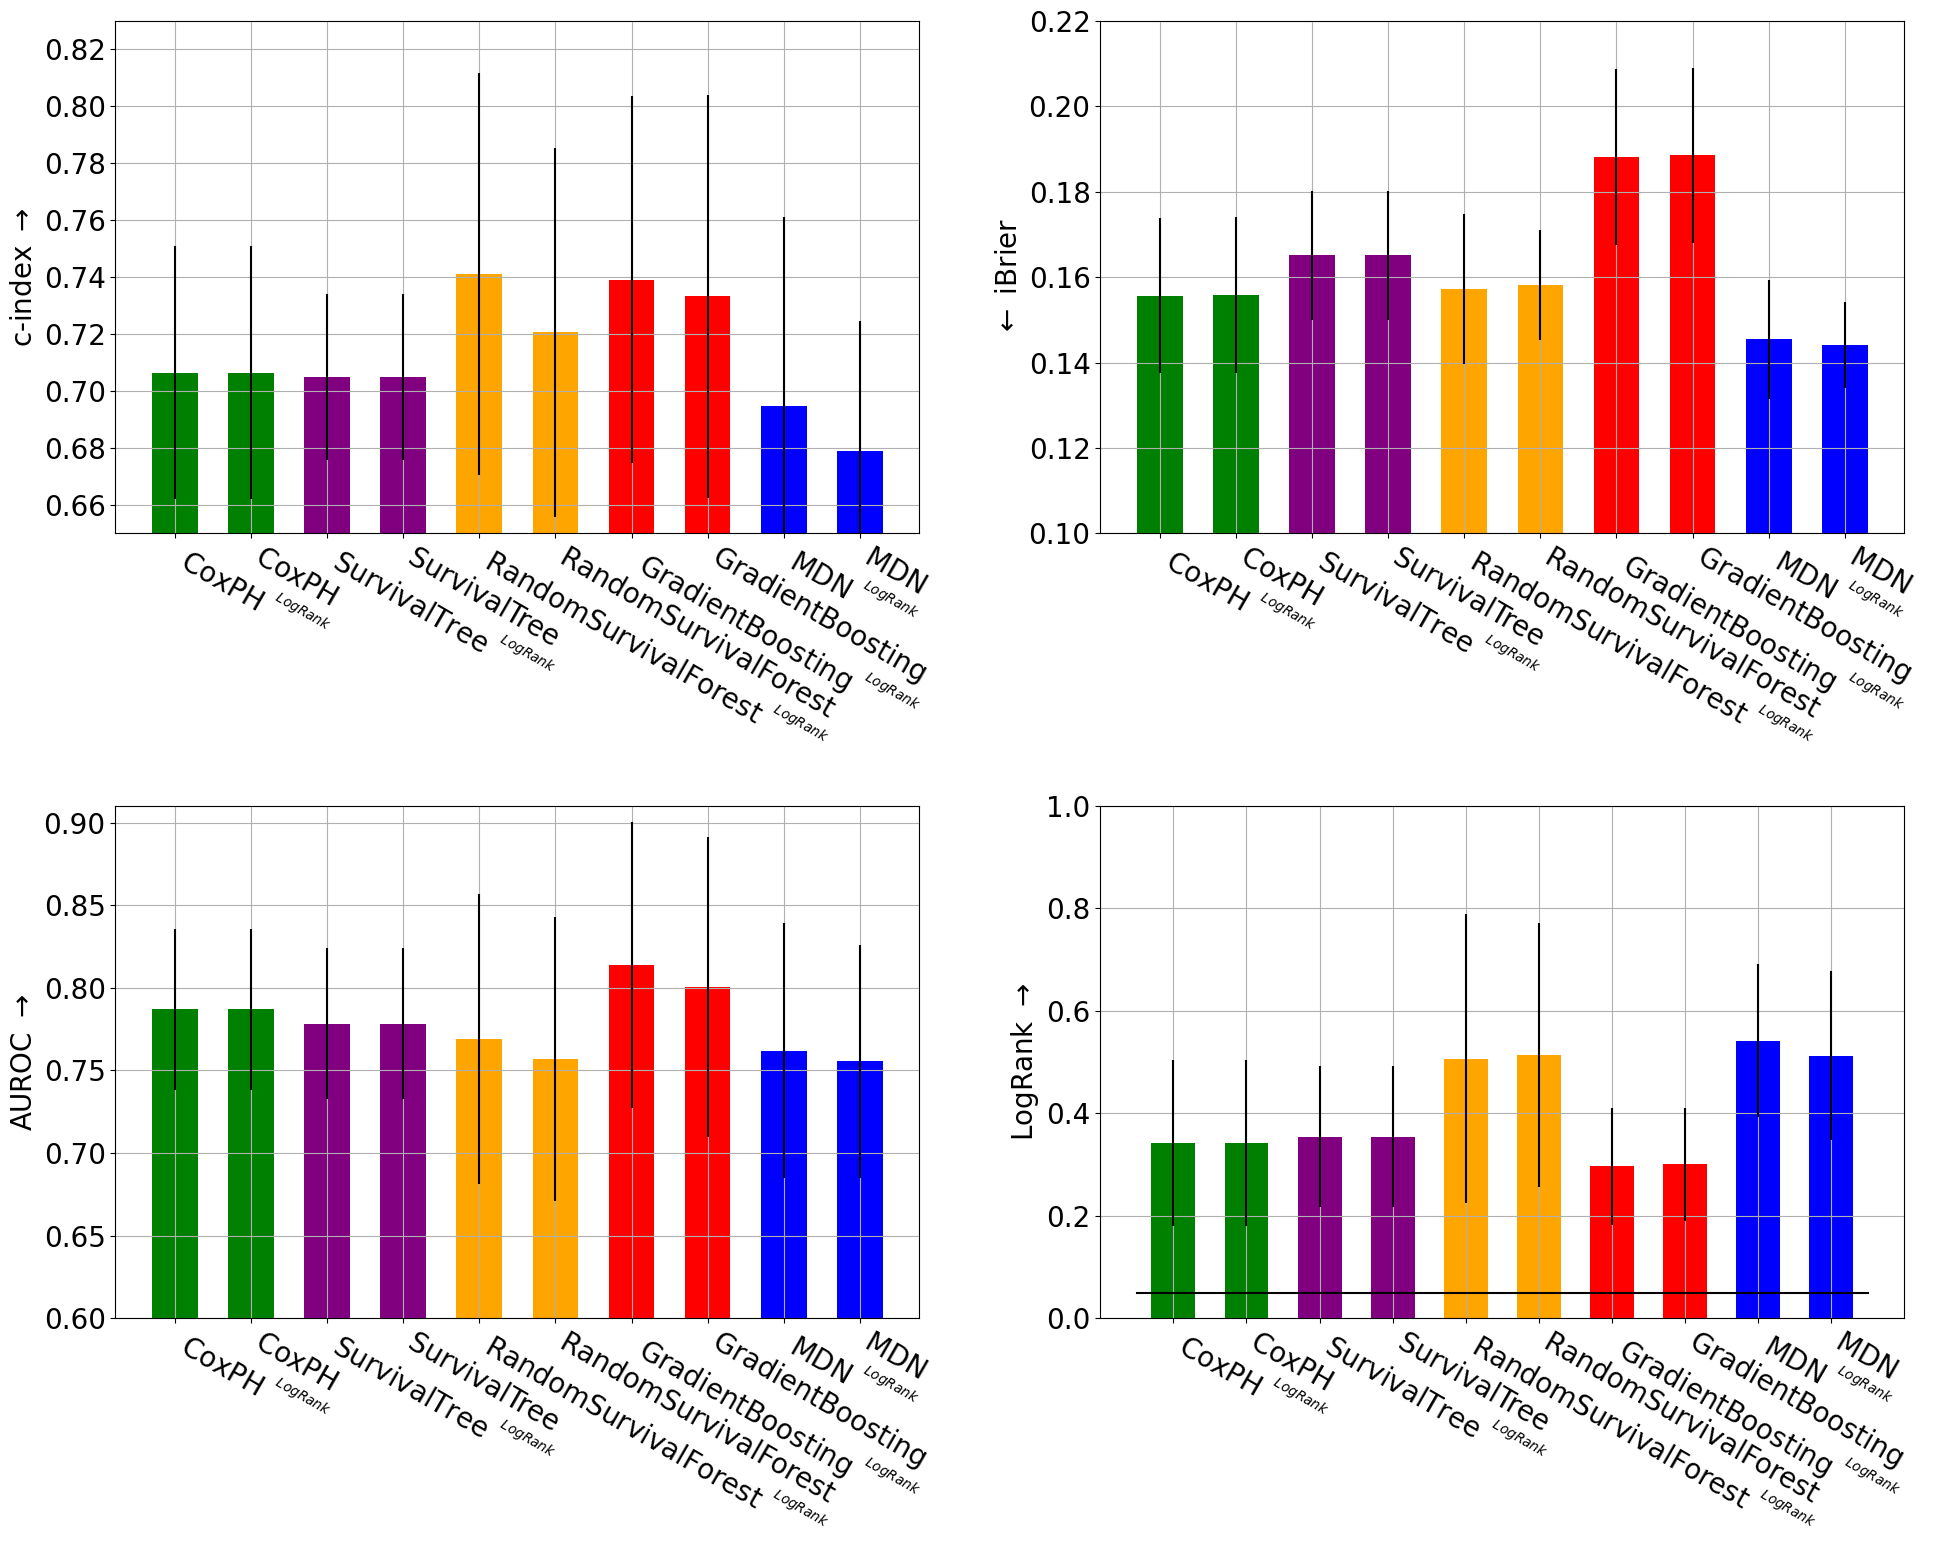

In [206]:
typ = "5Fold"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.65,0.83],[0.1,0.22],[0.6,0.91],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45, length = 40)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()

### Hold-out

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\2338835715.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\2338835715.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\2338835715.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_32748\2338835715.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


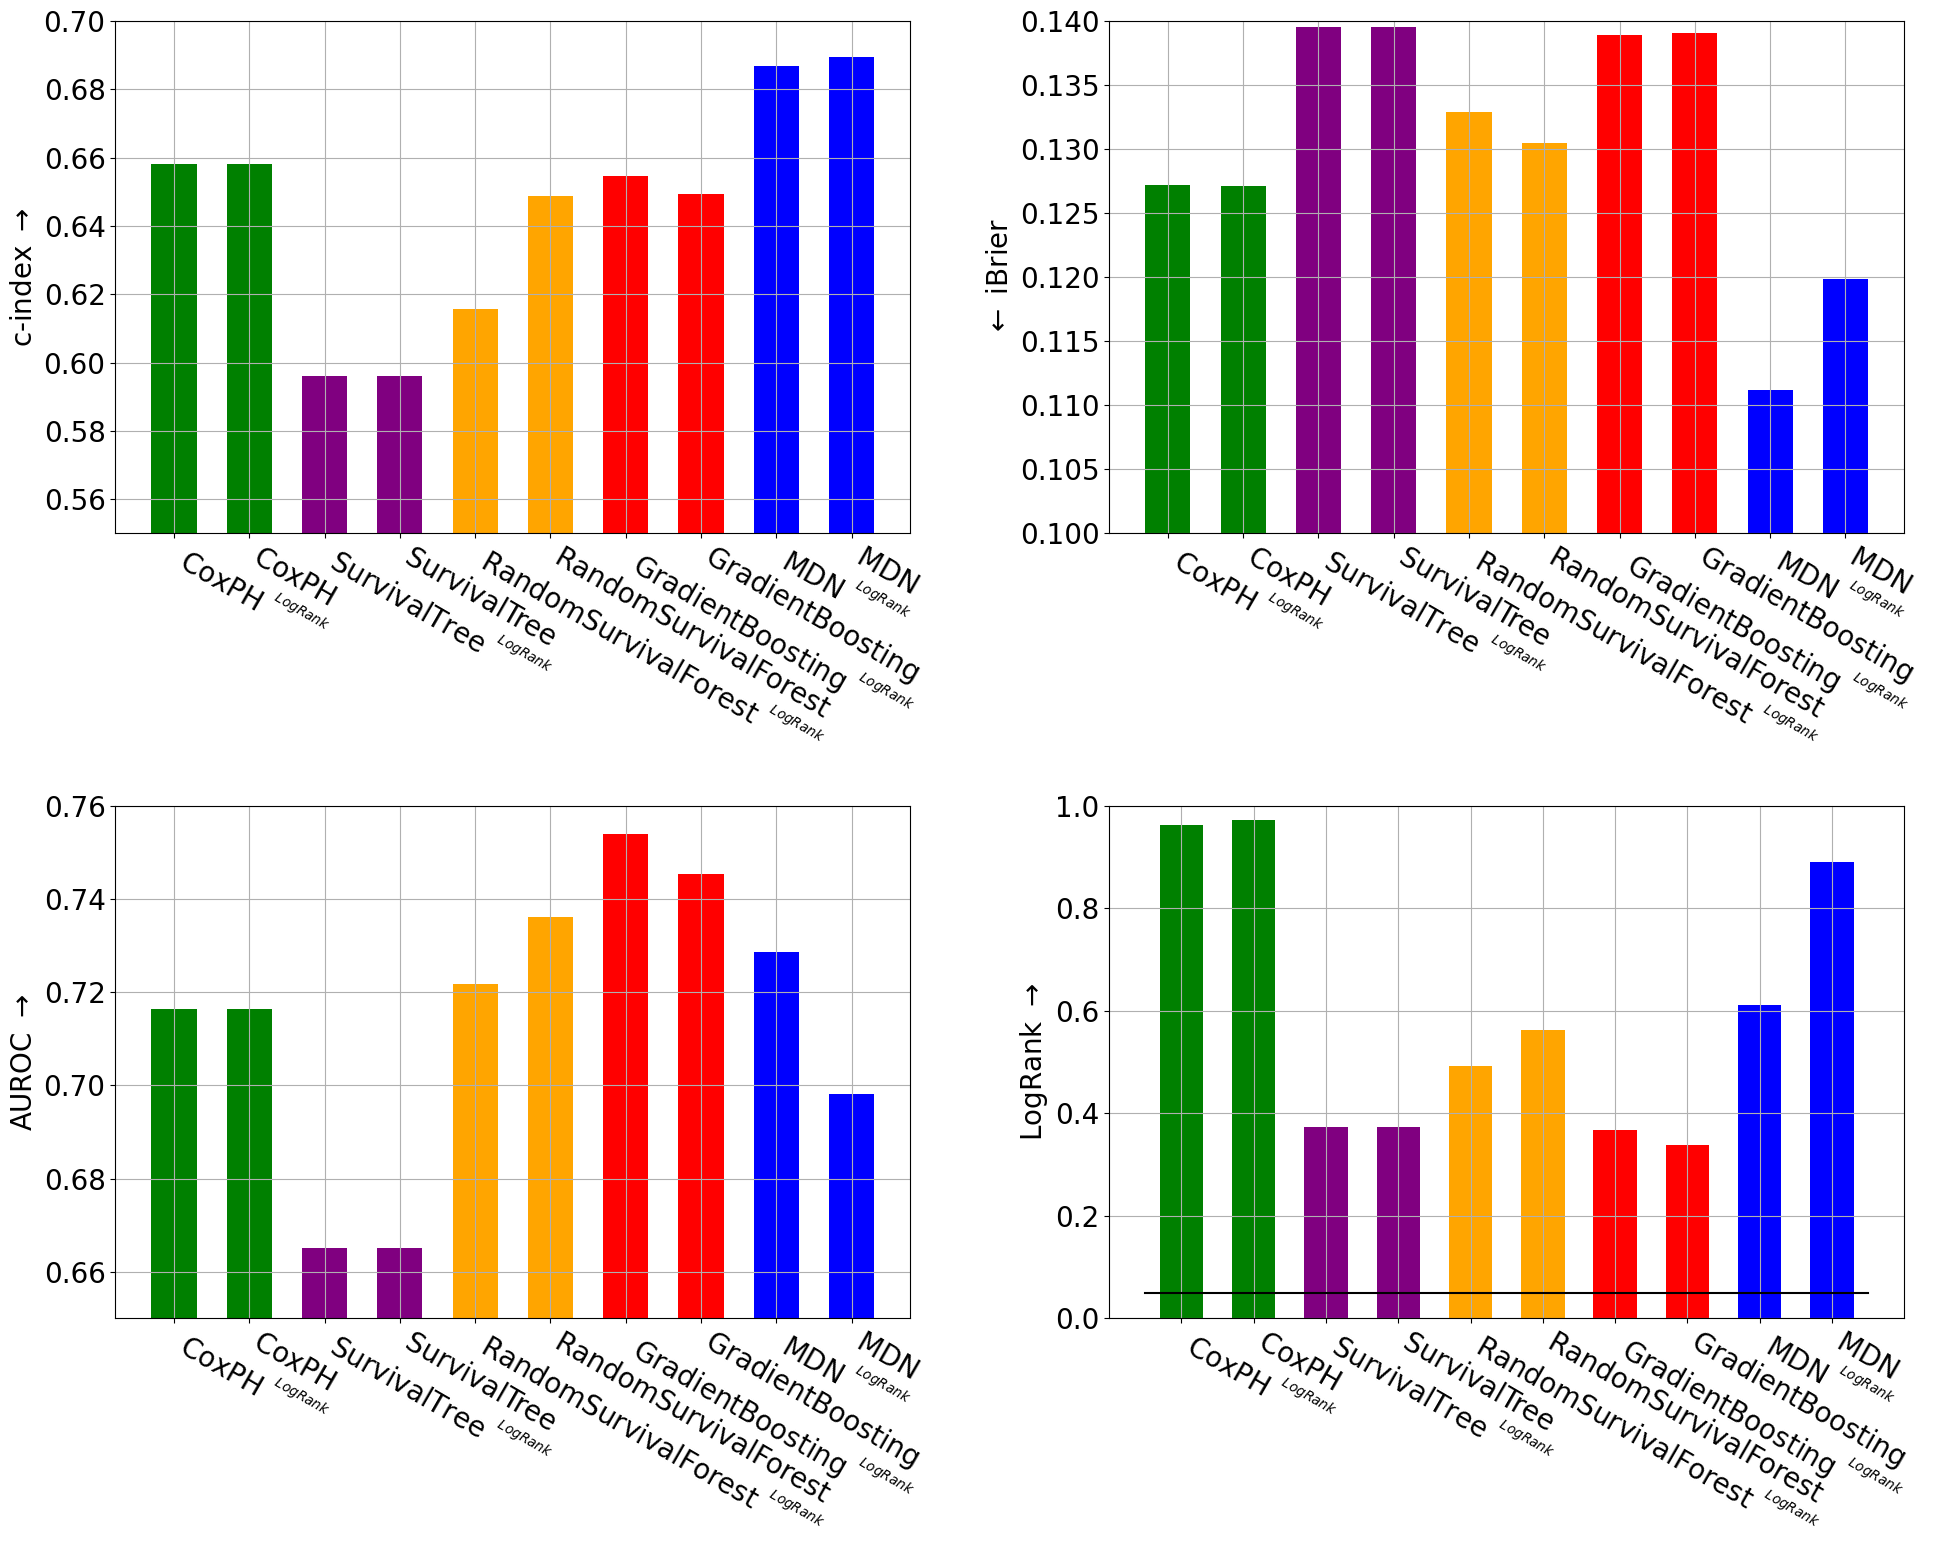

In [207]:
typ = "Hold-out"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.55,0.70],[0.1,0.14],[0.65,0.76],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()#rect=[0, 0.03, 1, 0.99])

## Compare Survival functions

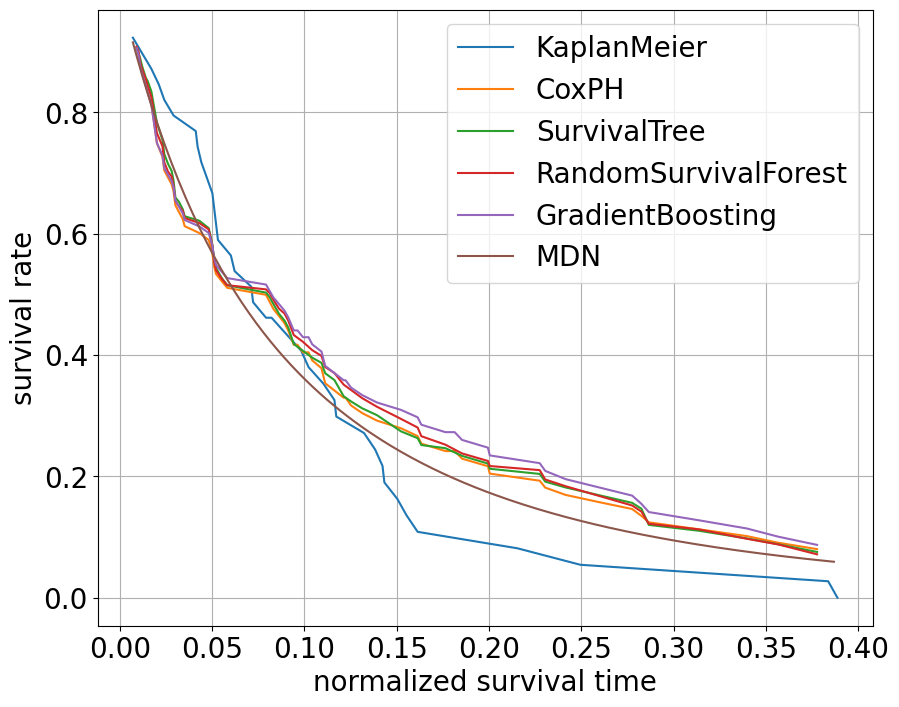

In [208]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True]
trials = list(product(models,opts))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            compare_survival["Model"].append(f"{trial[0]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Survival rate estimate for the population of the {NAME_PLOT} hold-out set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## Sensitvity Analysis
### Stratify by Score & Quantile

In [111]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True]
T_maxs = [0.25,0.5,0.75,1.0]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,T_maxs,typs,scores))

sensitivity_analysis_  = {"Model":[],
                         "Color":[],
                         "Legend":[],
                         "Type":[],
                         "Score":[],
                         "T_max":[],
                         "Ts":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_["Model"].append(trial[0])
    sensitivity_analysis_["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_["Legend"].append(trial[0])
    sensitivity_analysis_["Type"].append(trial[3])
    if trial[4] == "iBrier":
        sensitivity_analysis_["Score"].append("$\\leftarrow$ " + trial[4])
    else:
        sensitivity_analysis_["Score"].append(trial[4] + " $\\rightarrow$")
    sensitivity_analysis_["T_max"].append(trial[2])

    ts = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]):
            ts.append([(results_table["Uncensored_Reduction"][i]-0.05) if results_table["Model"][i] == "CoxPH" else
                       (results_table["Uncensored_Reduction"][i]-0.025) if results_table["Model"][i] == "SurvivalTree" else
                       (results_table["Uncensored_Reduction"][i]) if results_table["Model"][i] == "RandomSurvivalForest" else
                       (results_table["Uncensored_Reduction"][i]+0.025) if results_table["Model"][i] == "GradientBoosting" else
                       (results_table["Uncensored_Reduction"][i]+0.05) if results_table["Model"][i] == "MDN" else
                       results_table["Uncensored_Reduction"][i]
                      ][0])

            if trial[3] == "5Fold":
                means.append(results_table[trial[3]][trial[4]]["mean"][i])
                stds.append(1.96*results_table[trial[3]][trial[4]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[3]][trial[4]][i])
                stds.append(0)

    sensitivity_analysis_["Ts"].append(ts)
    sensitivity_analysis_["means"].append(means)
    sensitivity_analysis_["stds"].append(stds)

sensitivity_analysis_ = pd.DataFrame.from_dict(sensitivity_analysis_)

### Heatmap

In [359]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["Green","Purple","Orange","Red","Blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

sensitivity_analysis_heatmap  = {"Model":[],
                         "Color":[],
                         "Marker":[],
                         "Type":[],
                         "Score":[],
                         "xs":[],
                         "ys":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_heatmap["Model"].append(trial[0])
    sensitivity_analysis_heatmap["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Marker"].append([item[1] for item in zip(models,markers) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Type"].append(trial[2])
    if trial[3] == "iBrier":
        sensitivity_analysis_heatmap["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        sensitivity_analysis_heatmap["Score"].append(trial[3] + " $\\rightarrow$")
    #colors = []
    xs = []
    ys = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if ((results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1])):
            xs.append(results_table["Uncensored_Reduction"][i])
            ys.append(results_table["T_max"][i])
            if trial[2] == "5Fold":
                means.append(results_table[trial[2]][trial[3]]["mean"][i])
                stds.append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[2]][trial[3]][i])
                stds.append(0)

    sensitivity_analysis_heatmap["xs"].append(xs)
    sensitivity_analysis_heatmap["ys"].append(ys)
    sensitivity_analysis_heatmap["means"].append(means)
    sensitivity_analysis_heatmap["stds"].append(stds)

sensitivity_analysis_heatmap = pd.DataFrame.from_dict(sensitivity_analysis_heatmap)

### Plots
#### 5Fold

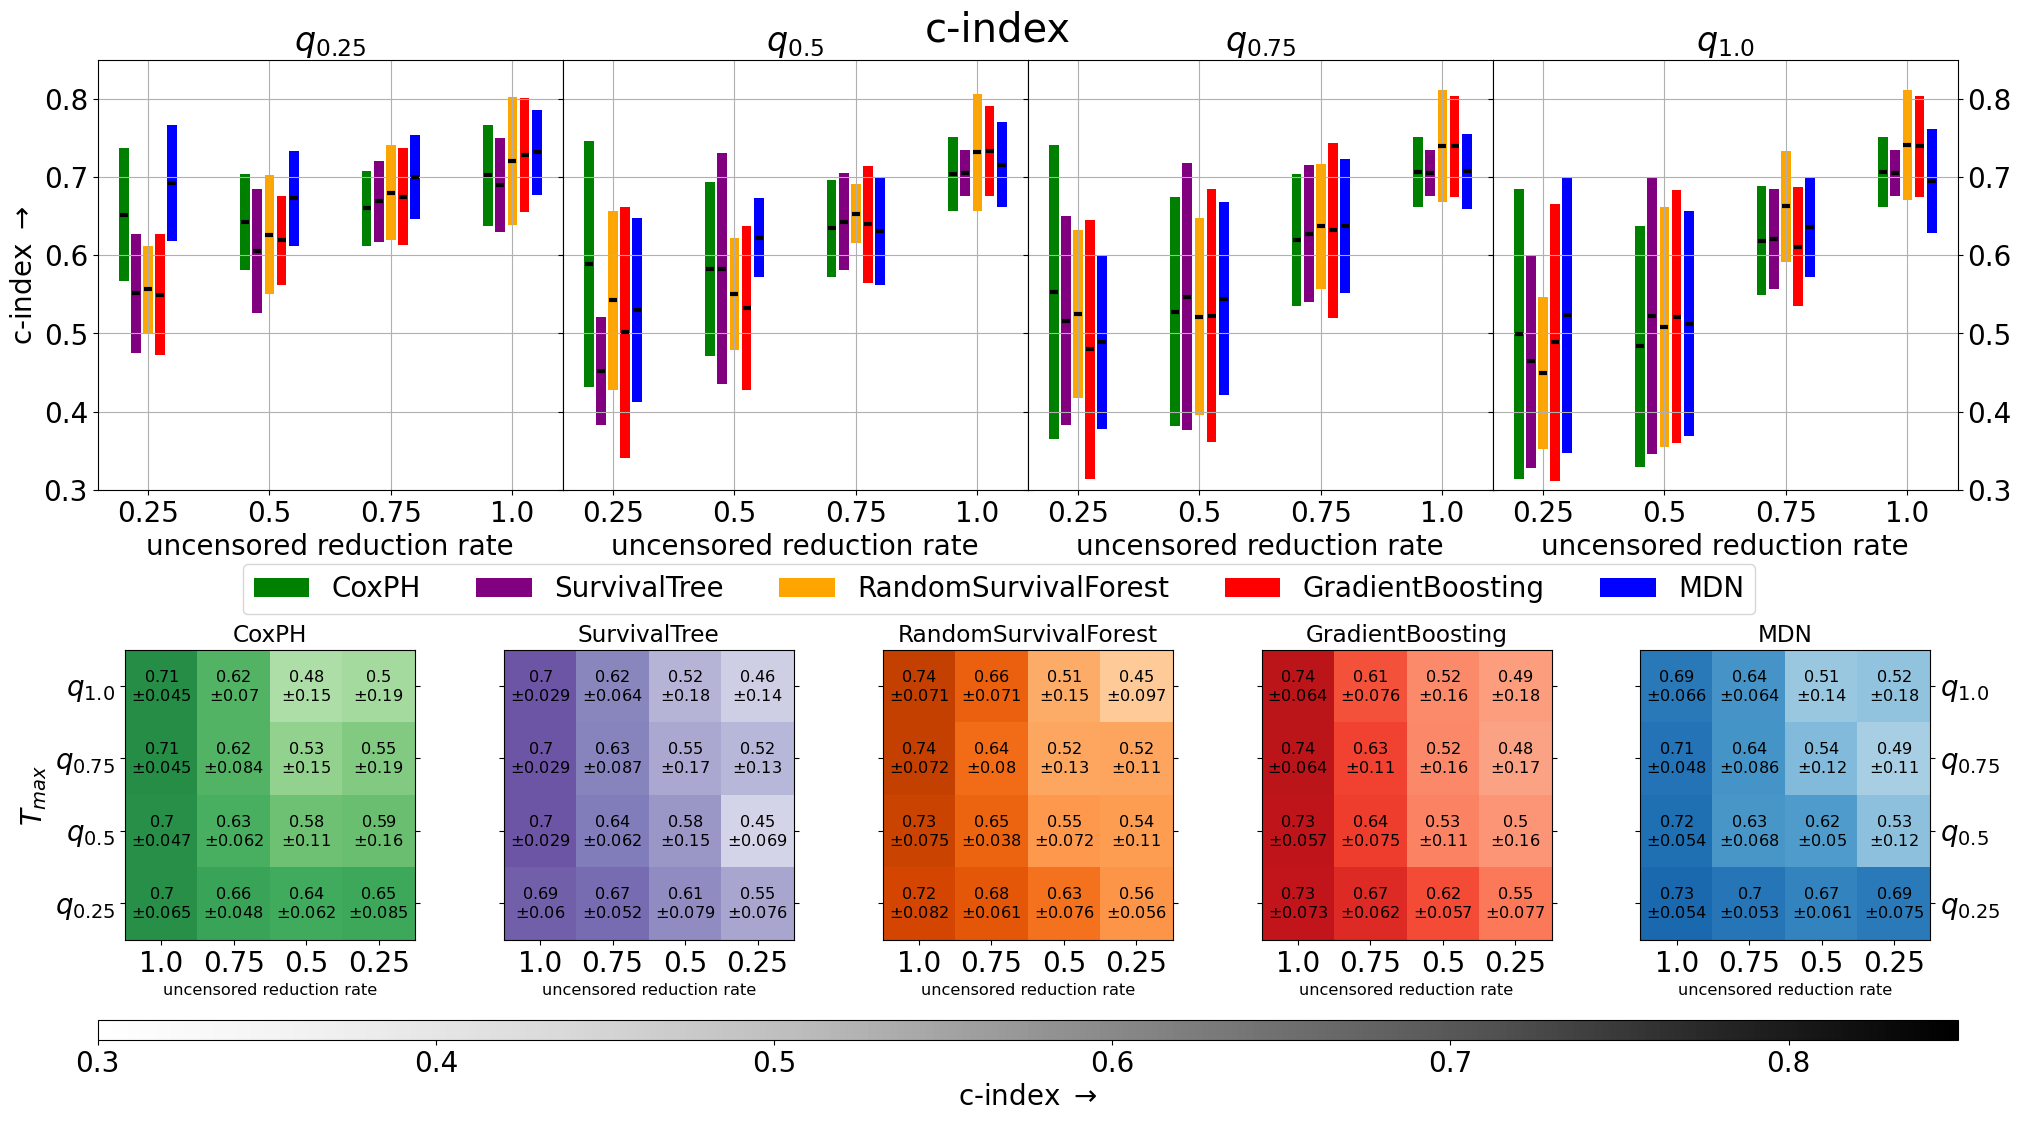

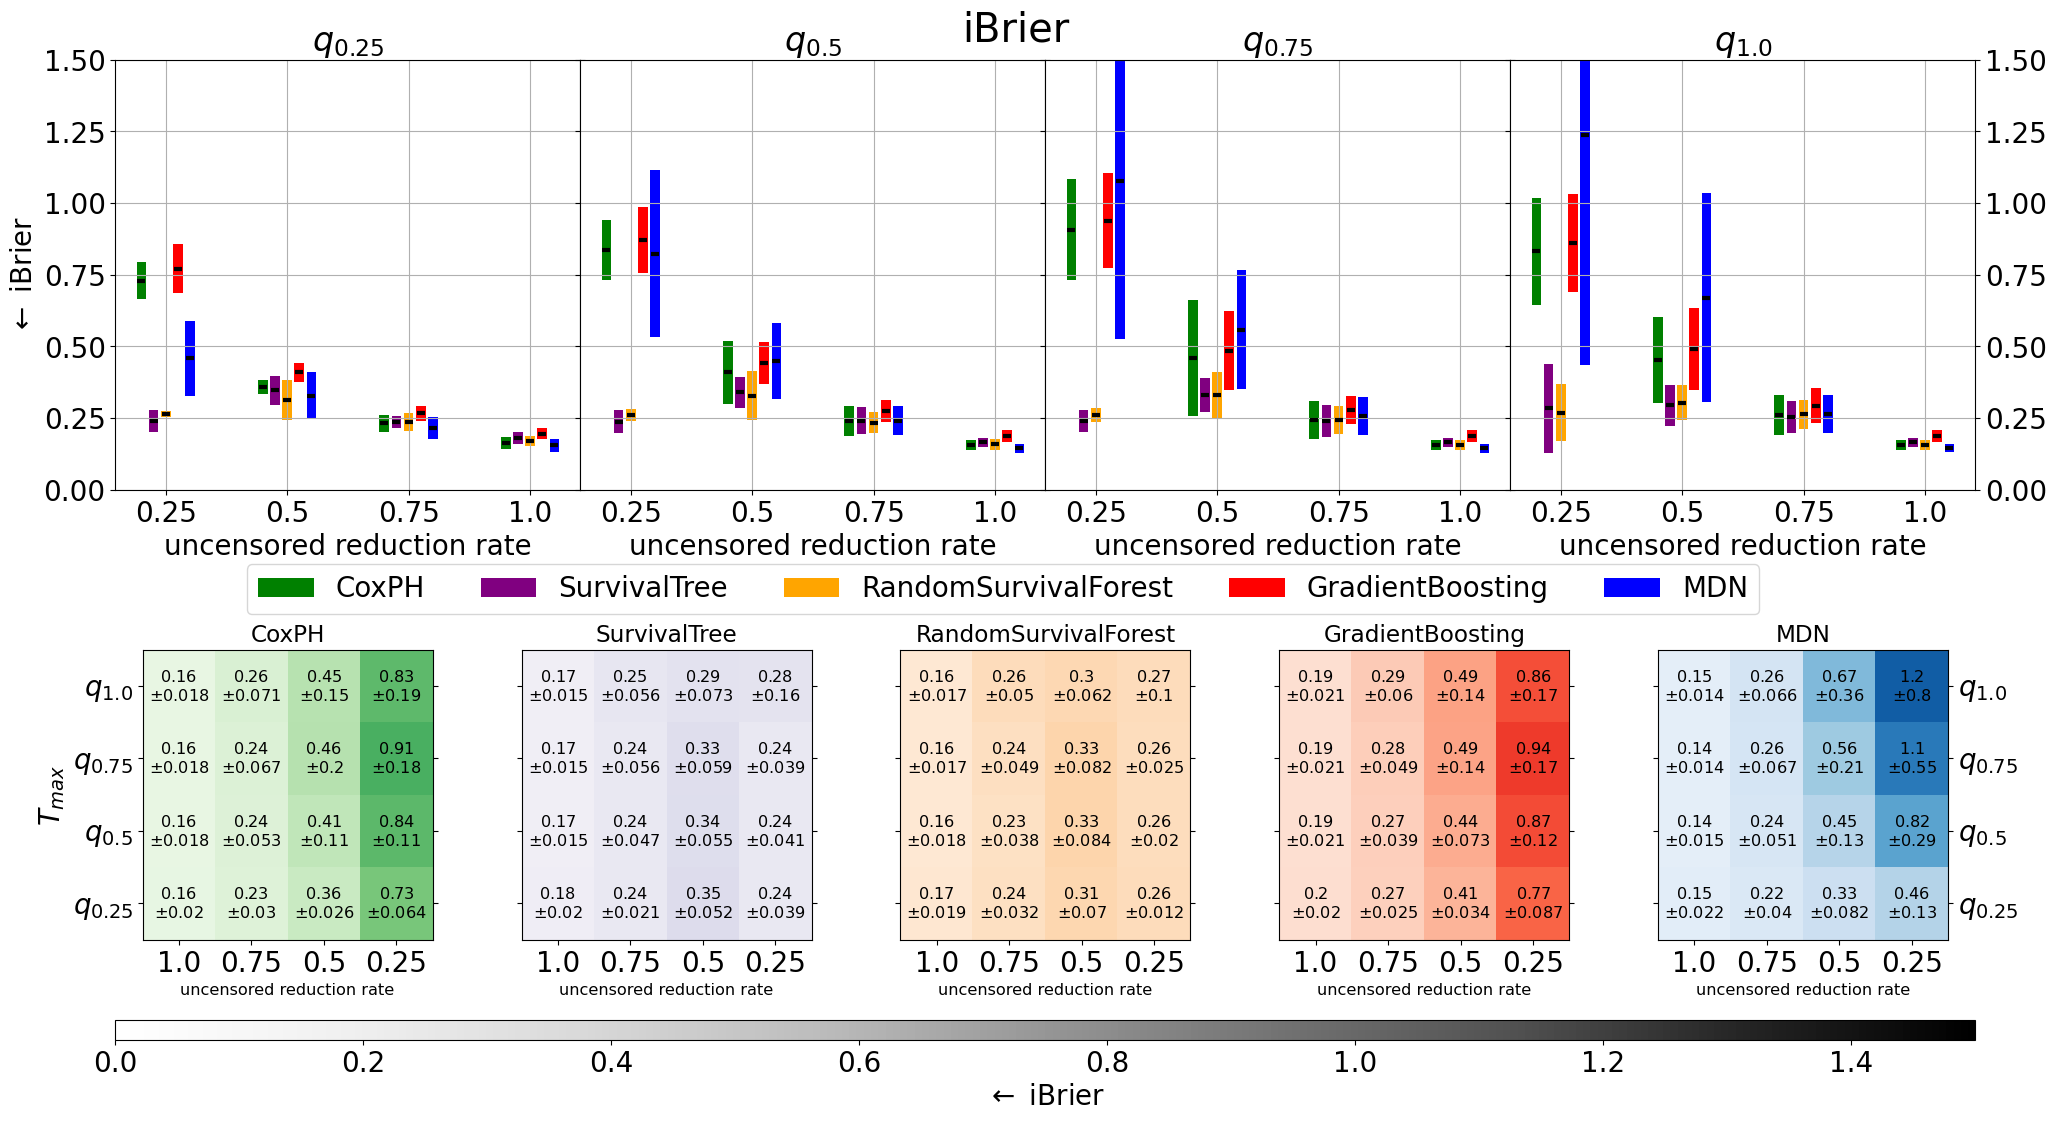

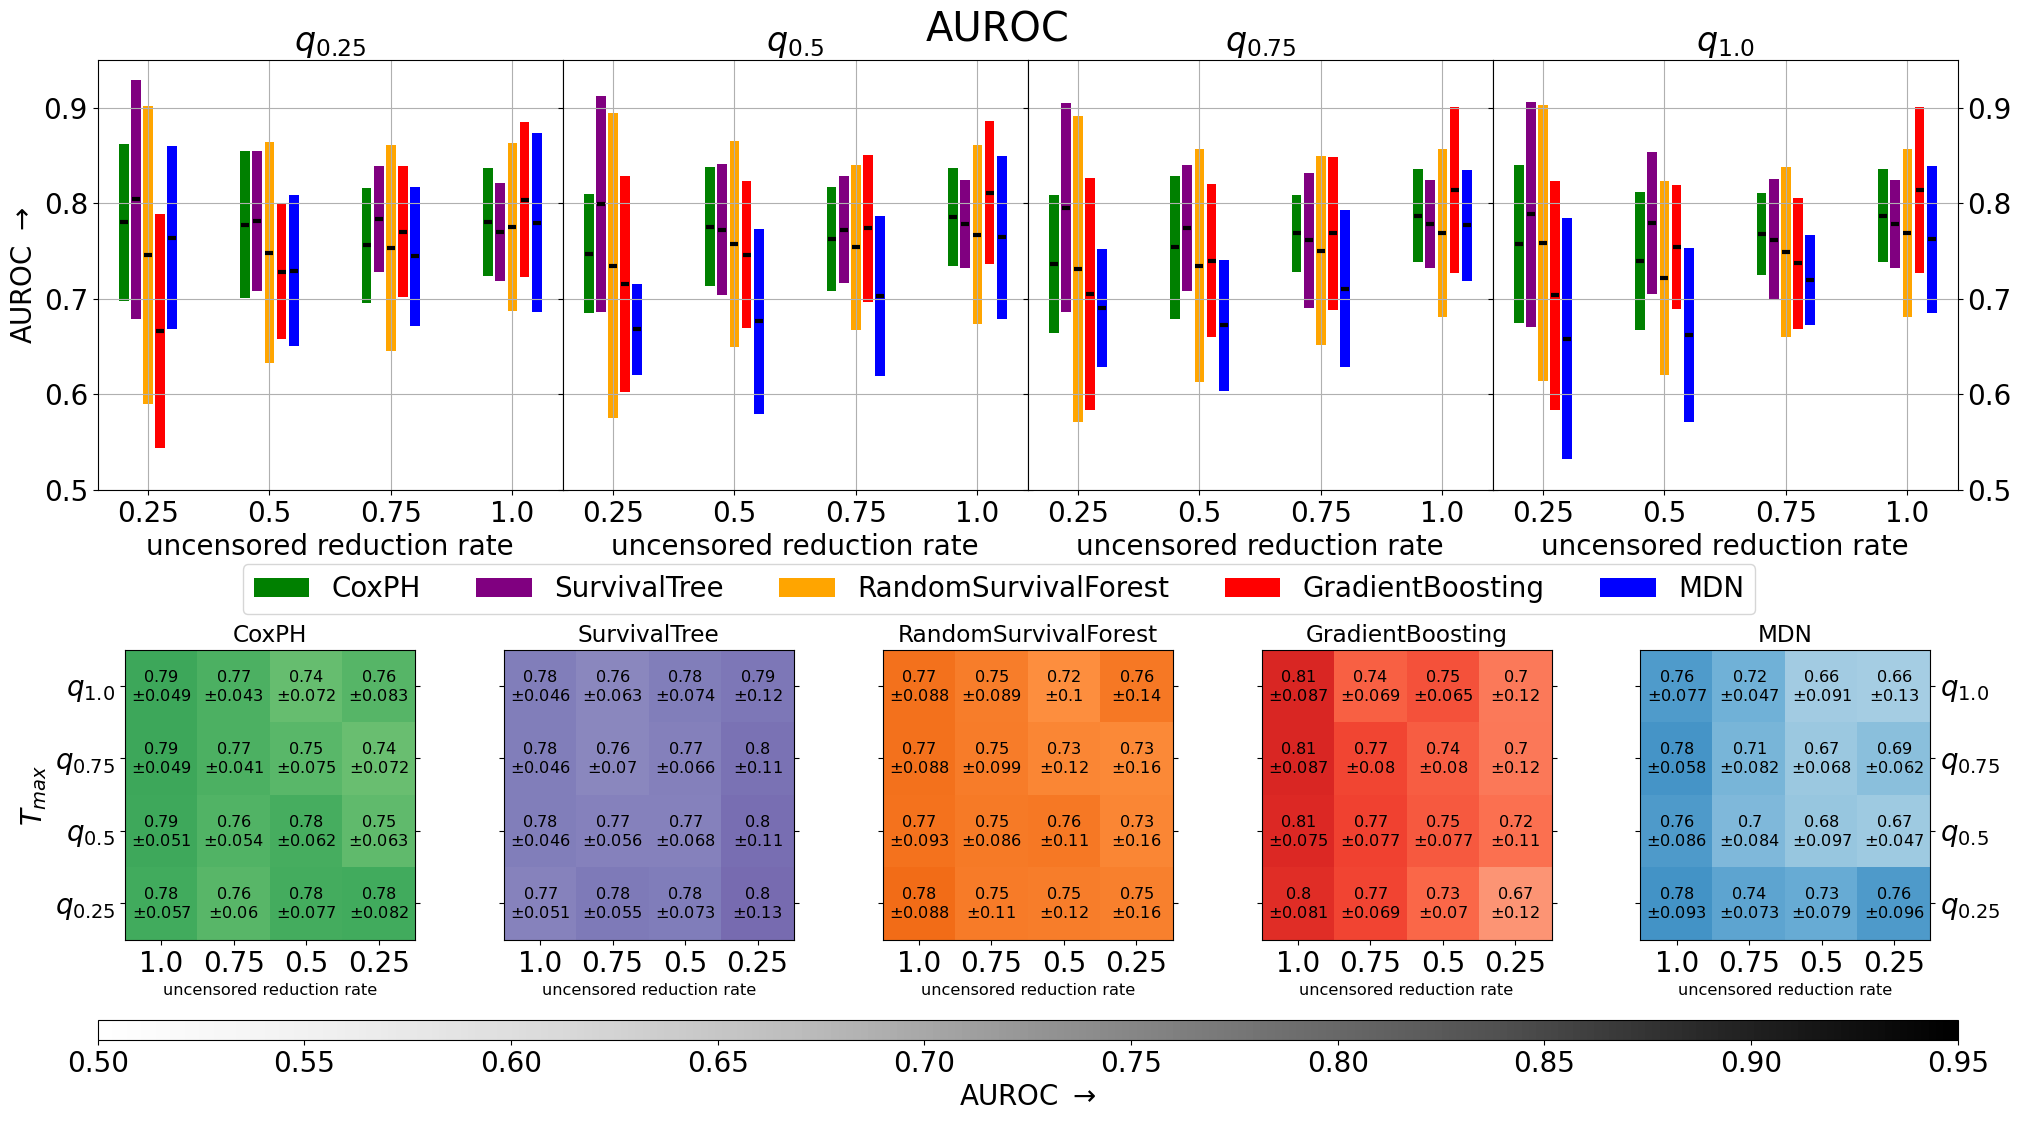

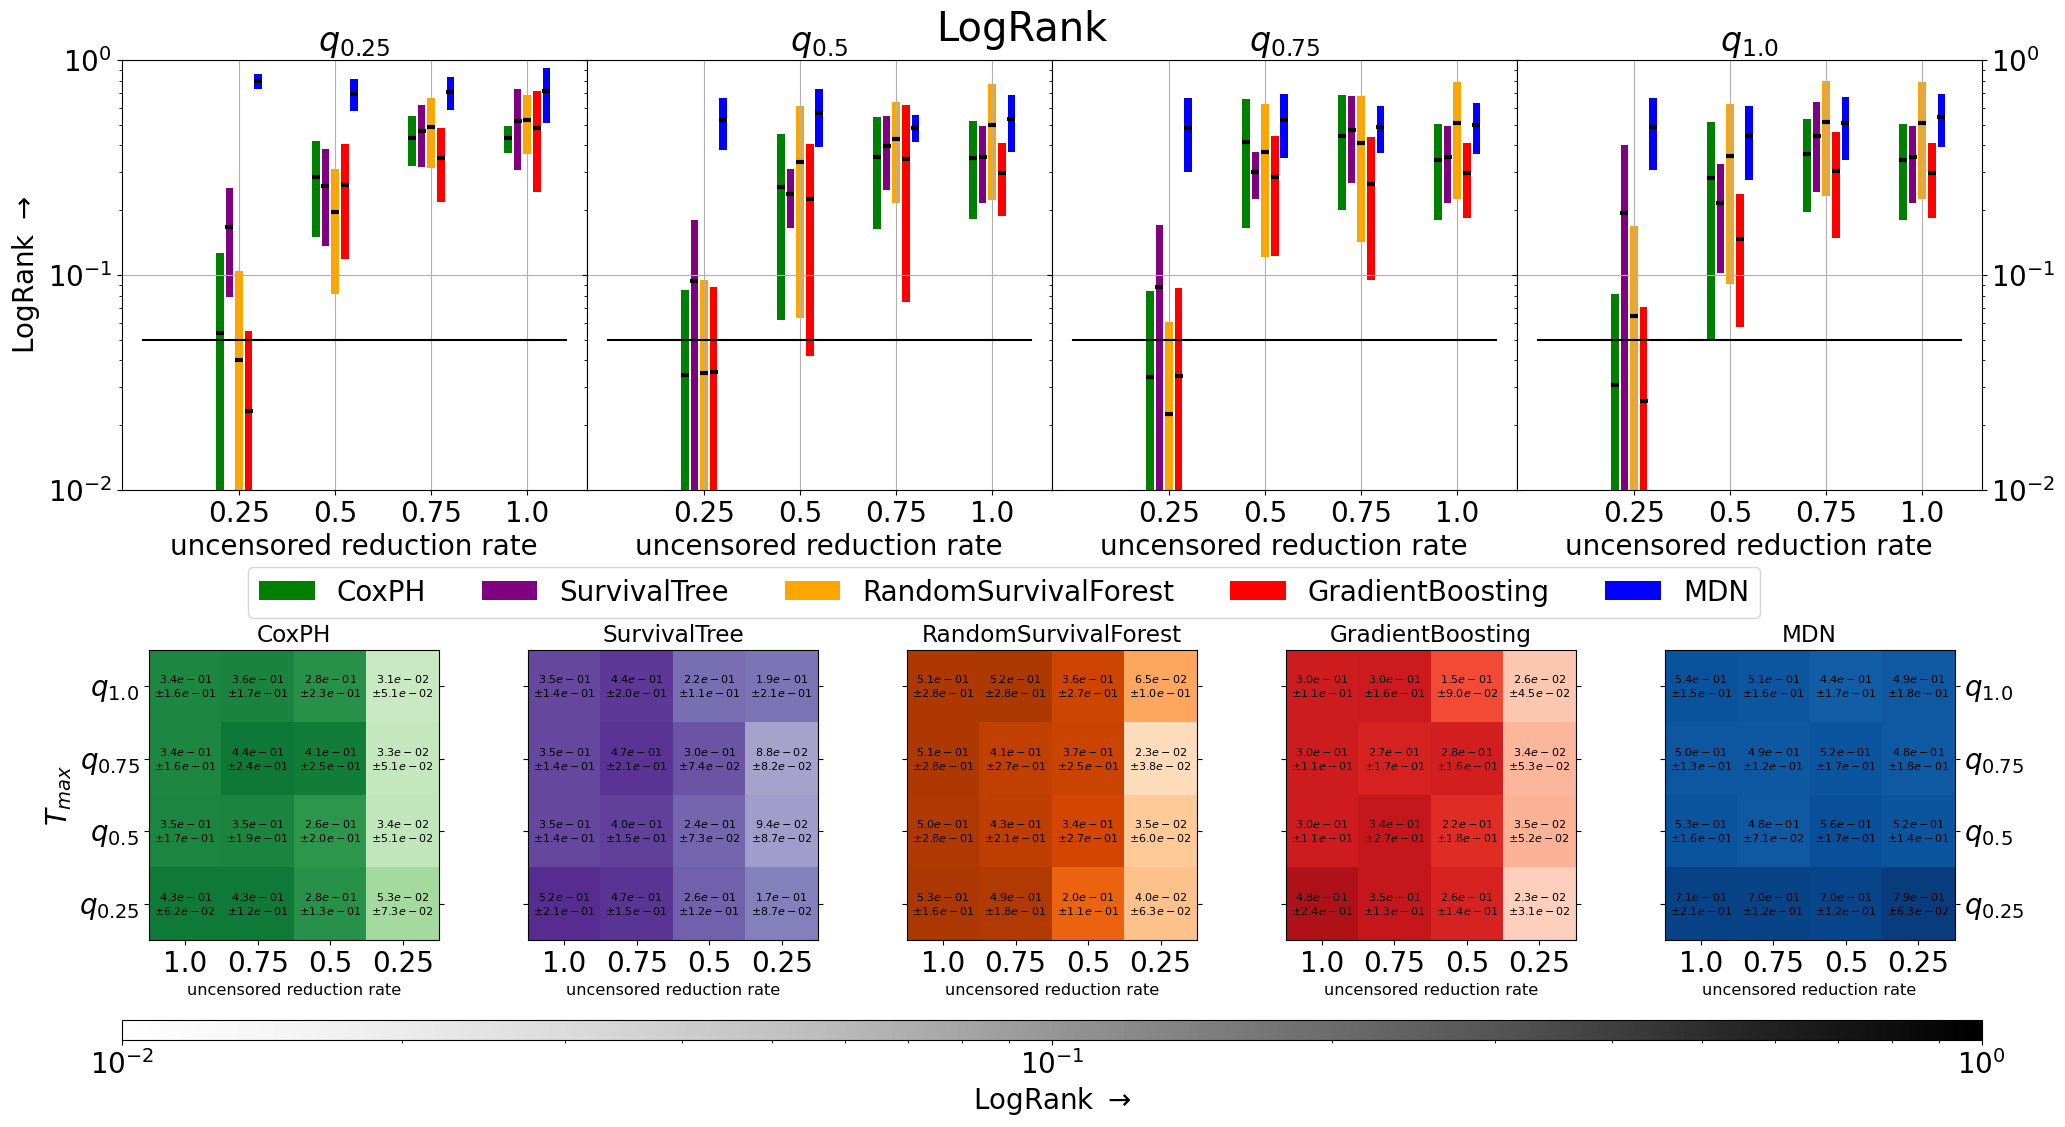

In [368]:
typ = "5Fold"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.3,0.85],[0.0,1.5],[0.5,0.95],[1e-2,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            # Do the Japanese candles
            bar_axs[loc].plot(row["Ts"], row["means"], ls = "", marker = "_", markeredgewidth = 3, color = "black")
            bar_axs[loc].bar(row["Ts"], height = np.array(row["stds"])*2,width = 0.02, bottom = np.array(row["means"]) - np.array(row["stds"]), color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].yaxis.set_ticks_position('both')
        bar_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")



            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

#### Hold-out

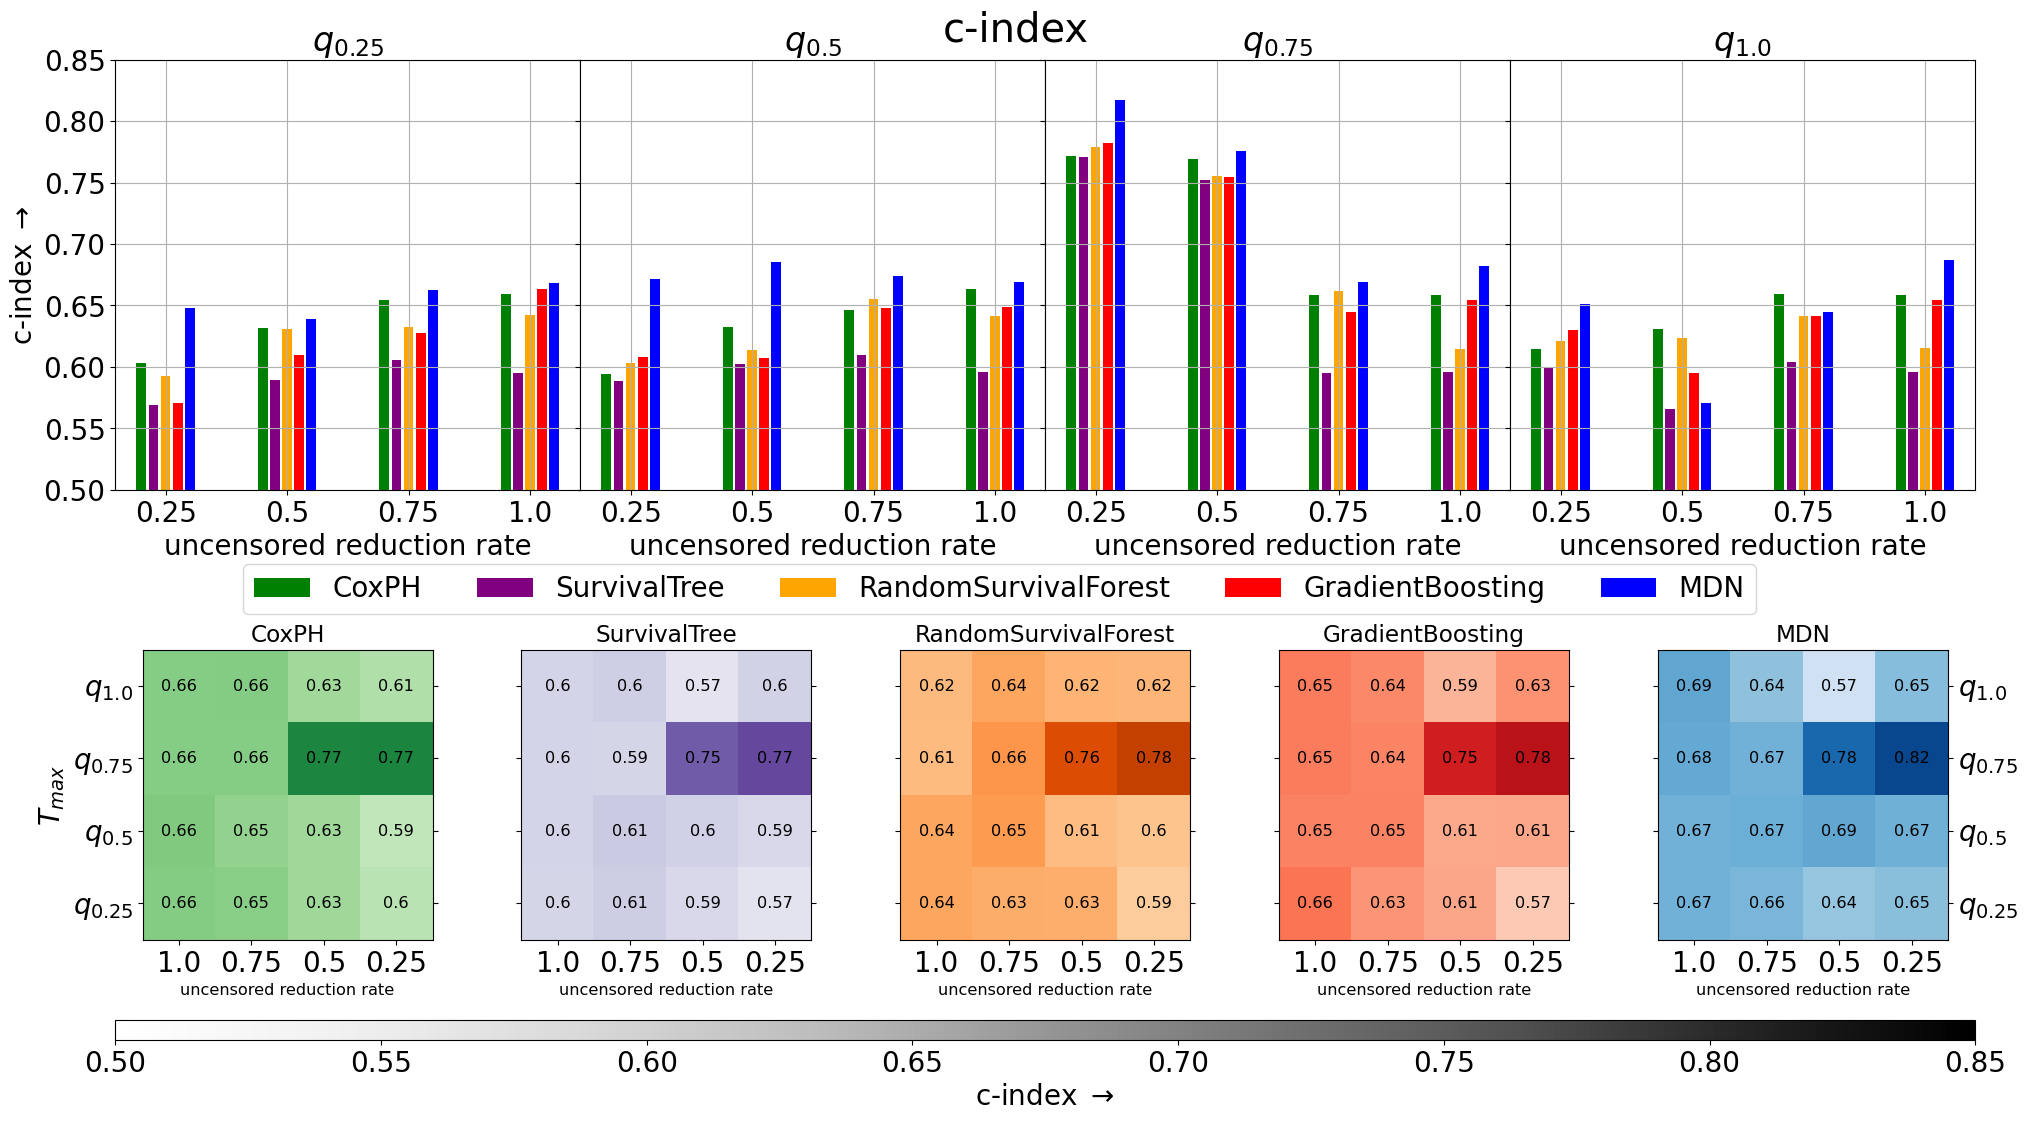

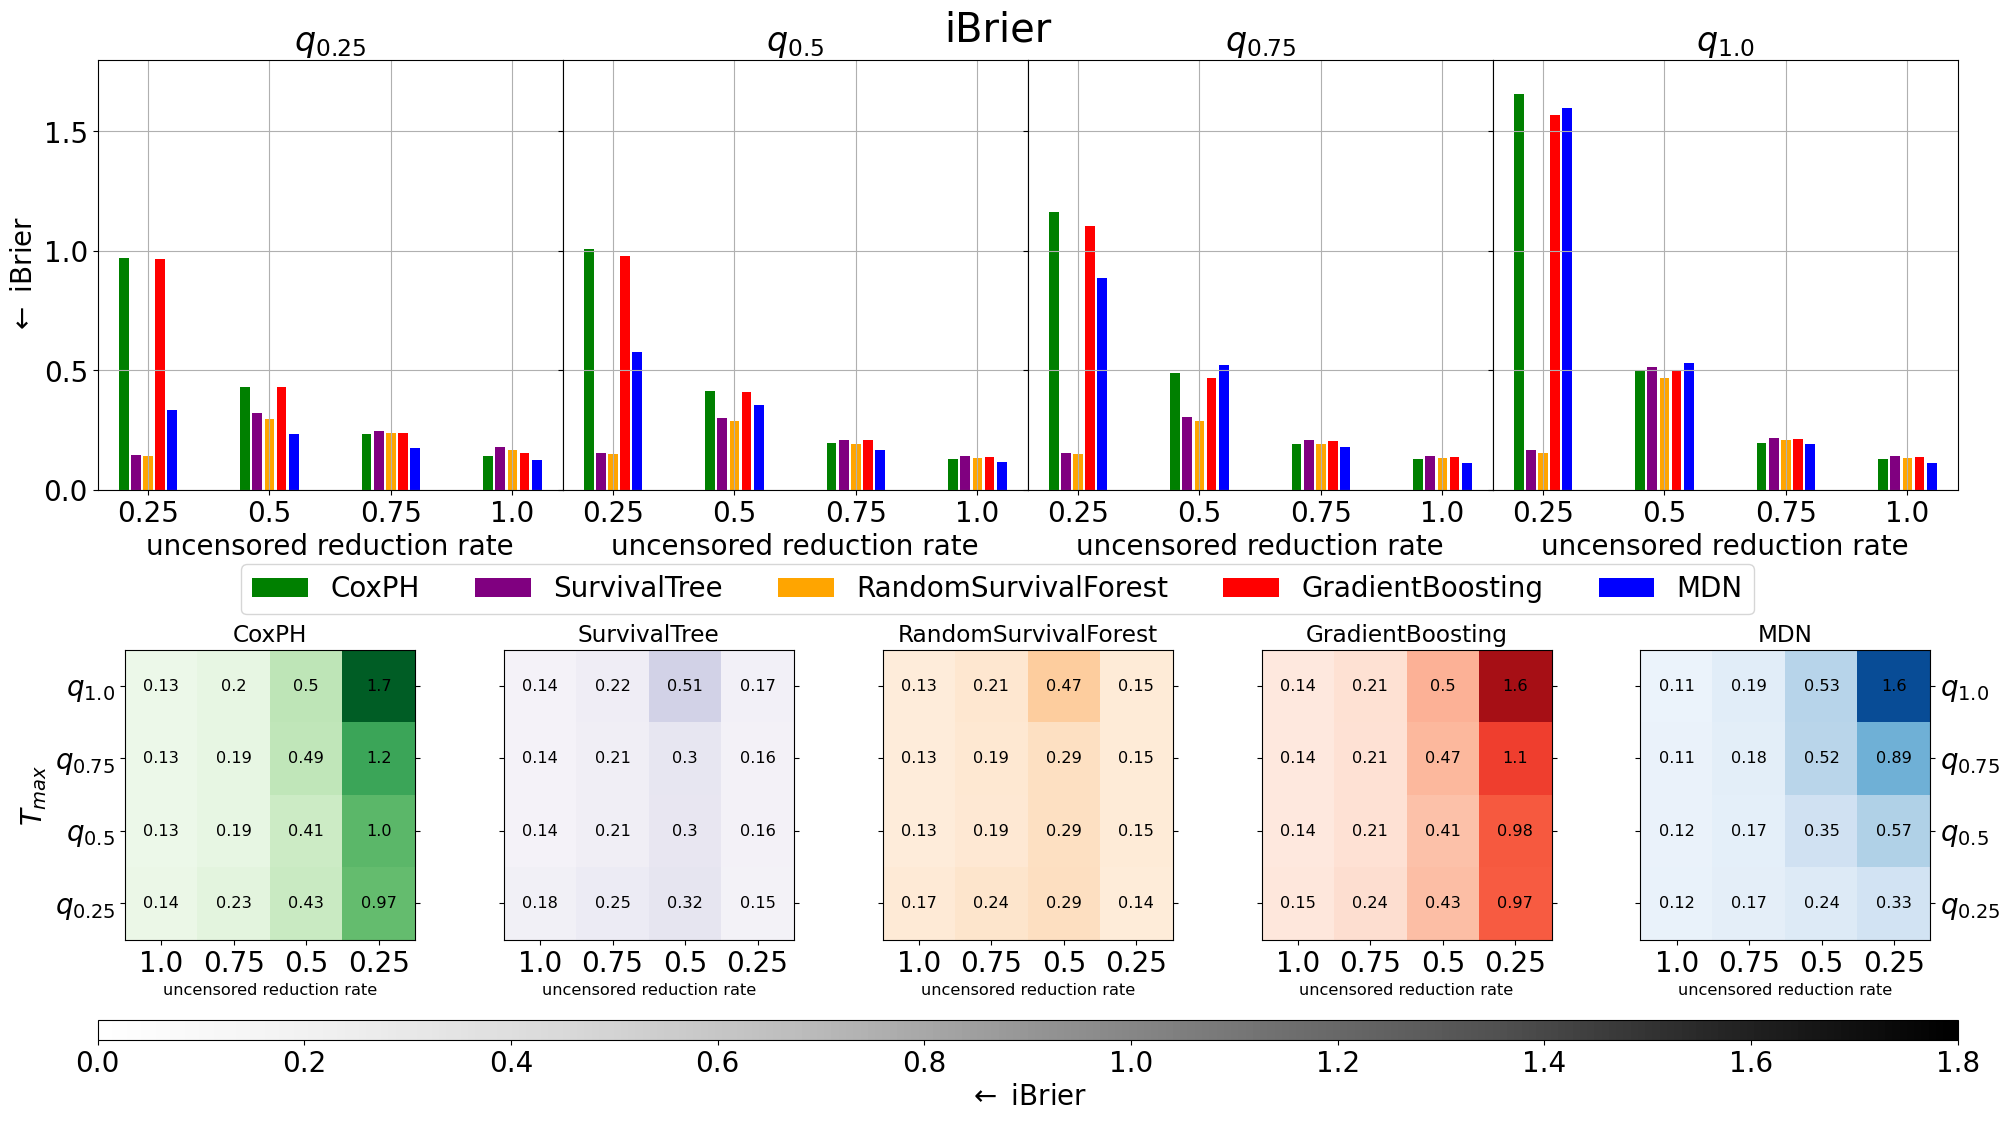

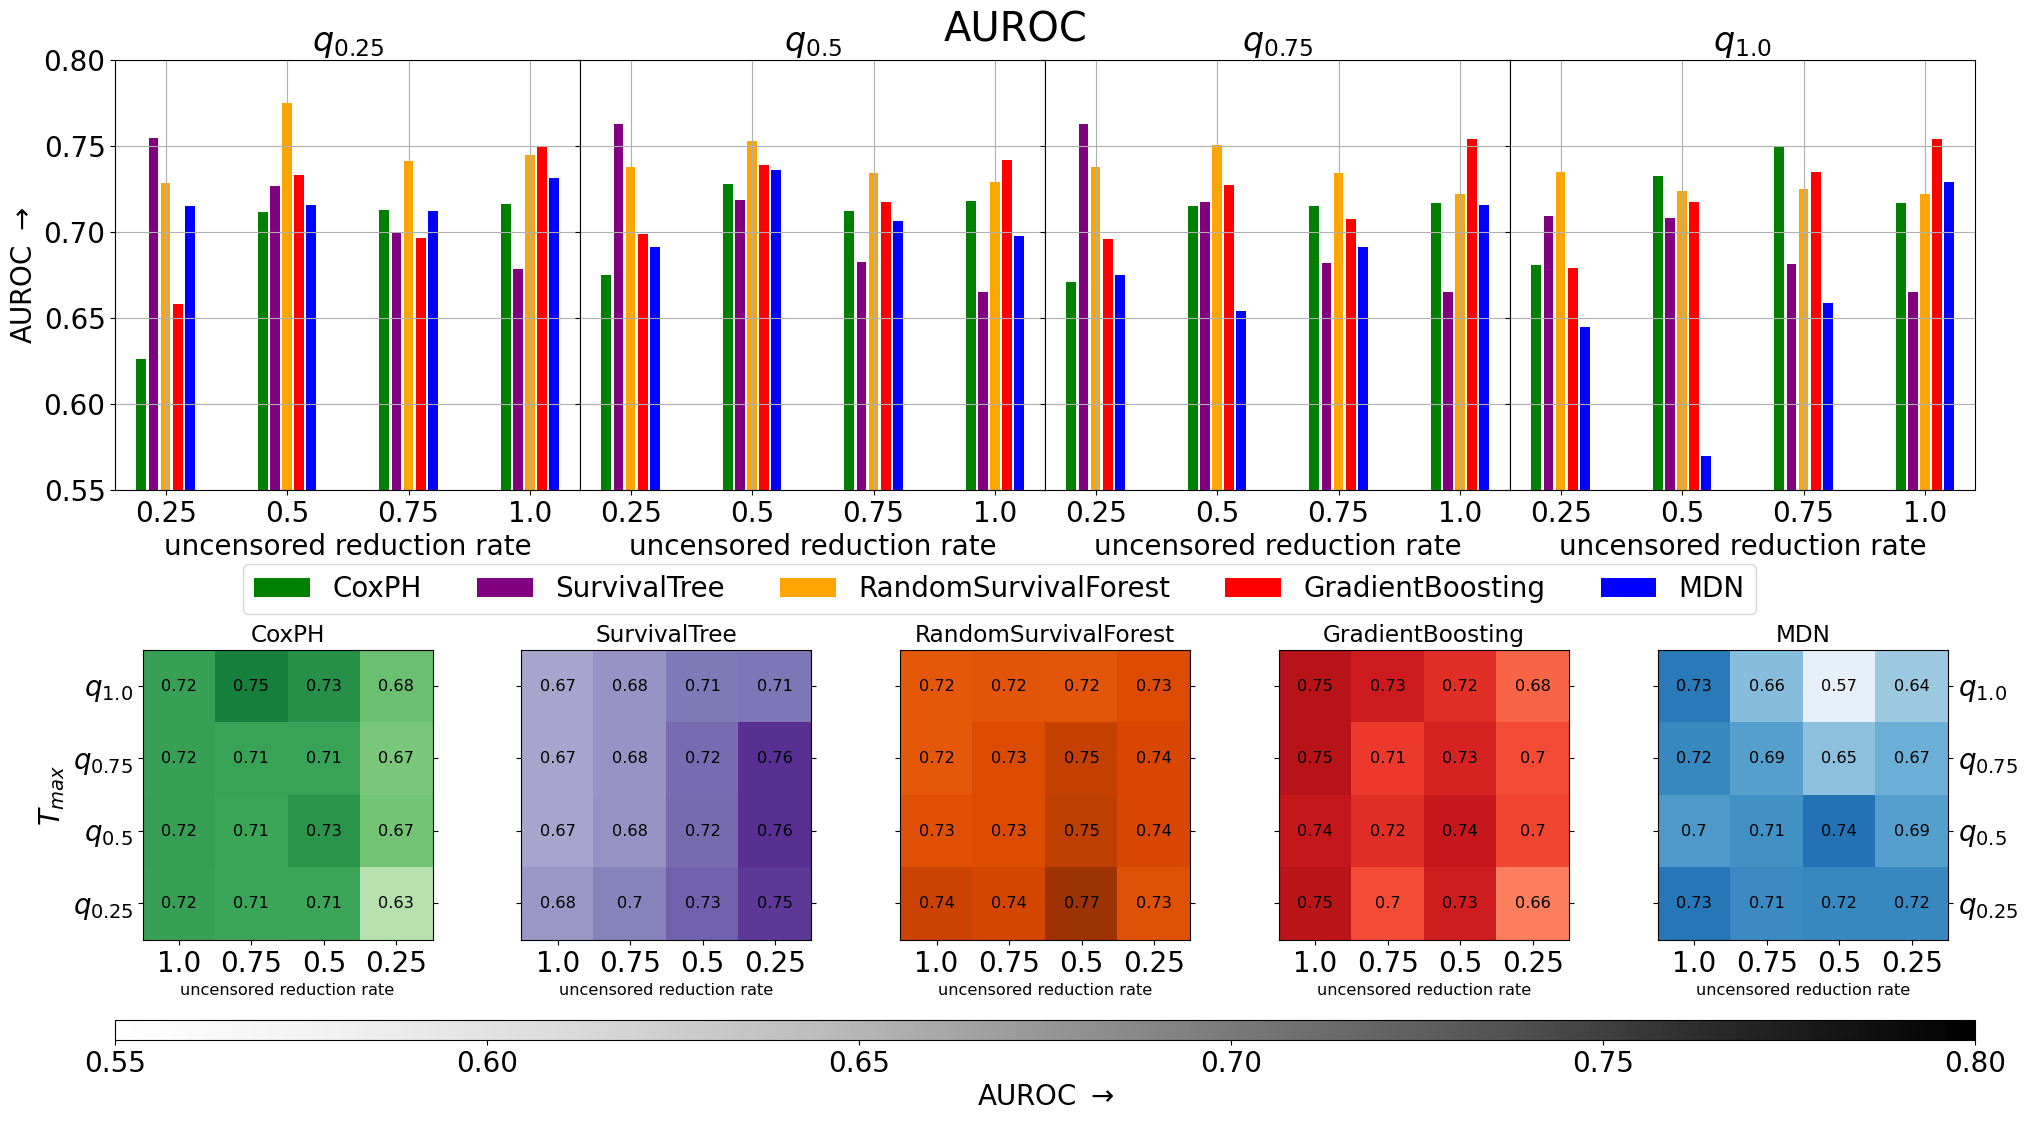

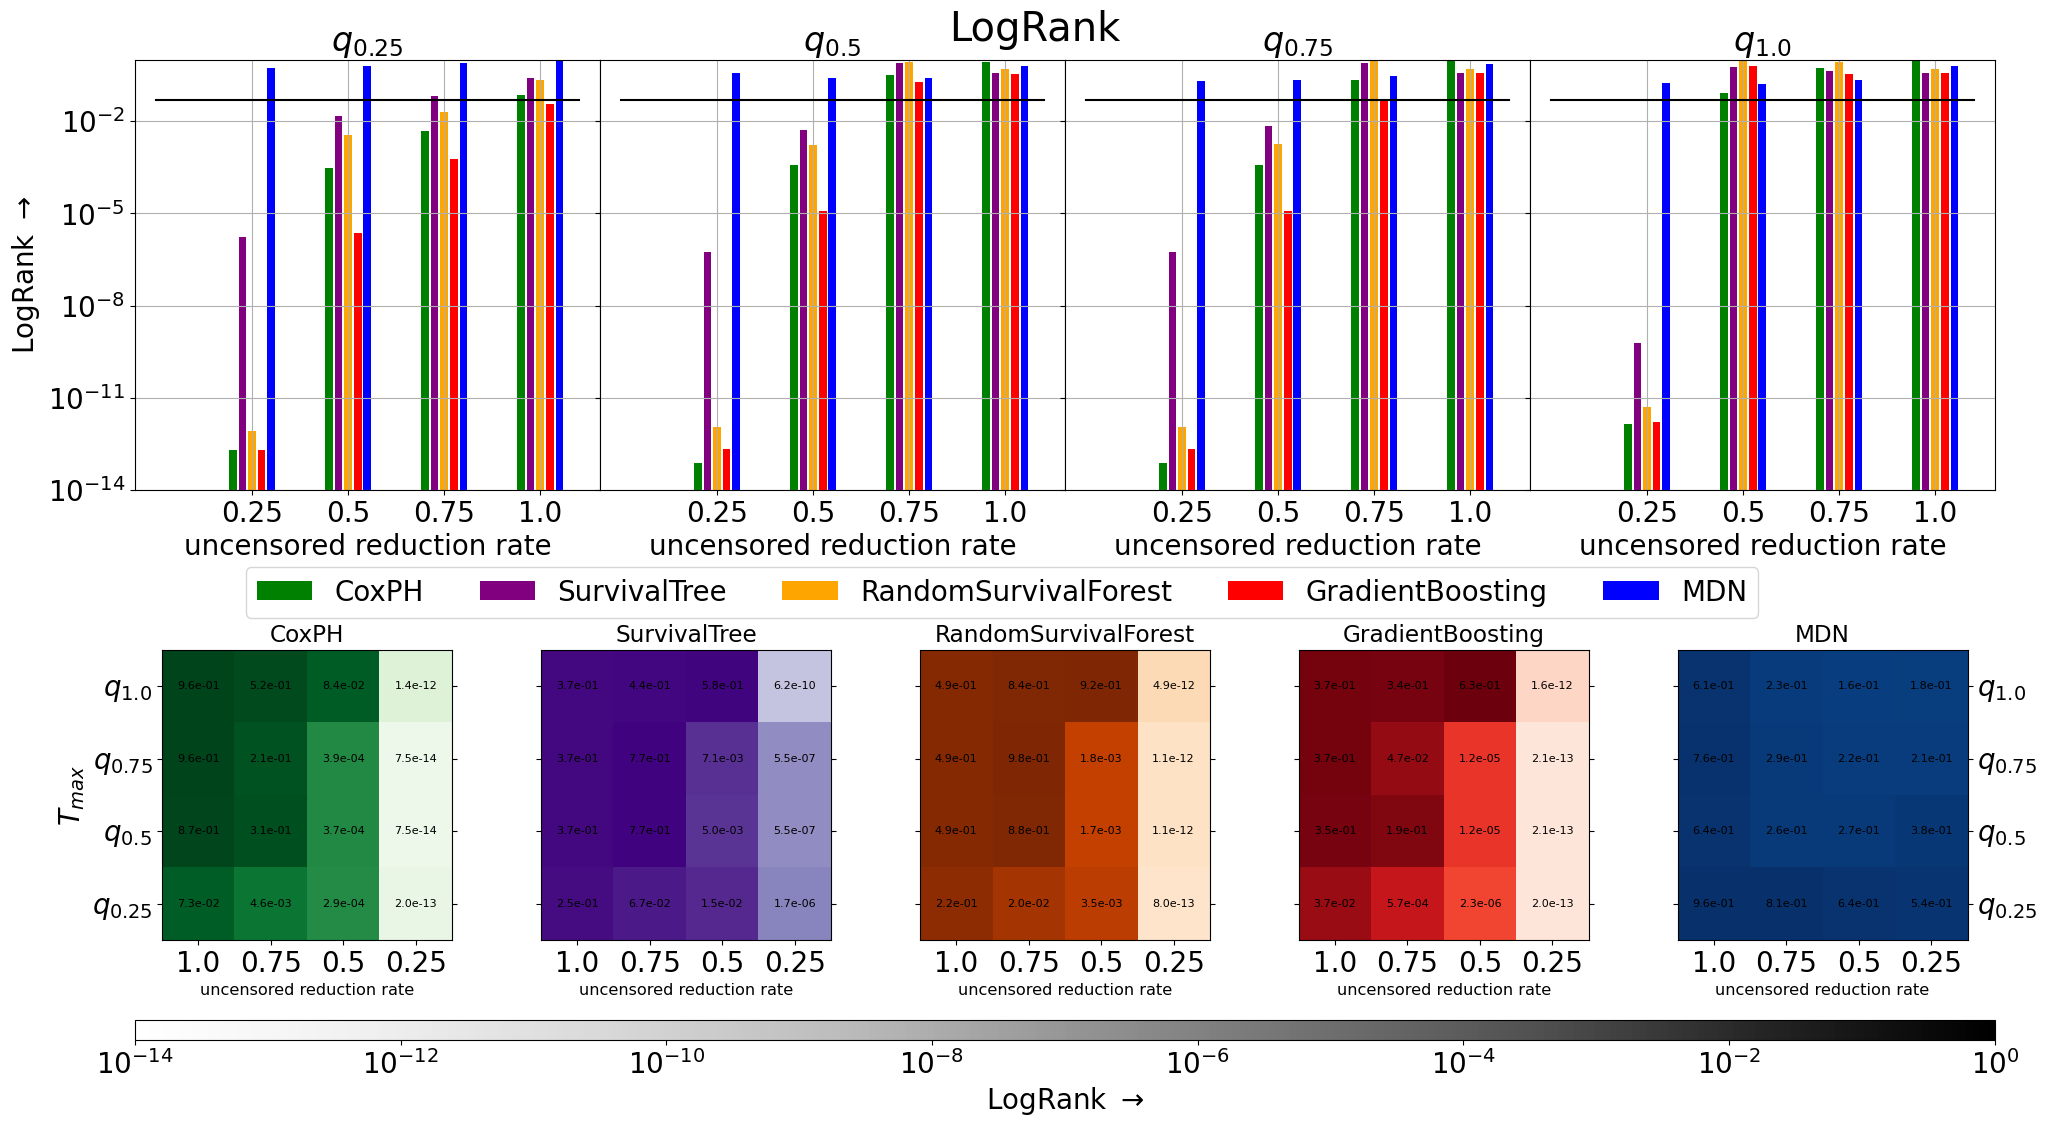

In [369]:
typ = "Hold-out"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.5,0.85],[0.0,1.8],[0.55,0.8],[1e-14,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            eb = bar_axs[loc].bar(row["Ts"], height = row["means"],width = 0.02, yerr = row["stds"], color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    #clr = ScalarMappable(cmap = f"Greys_r", norm = norm).to_rgba(np.array(row.means).reshape(4,4)[i,j])
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(float(np.array(row.stds).reshape(4,4)[i,j]))
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

### Correlation

In [120]:
from scipy.stats import spearmanr

In [131]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
trials = list(product(models,opts,typs))

sensitivity_analysis_corr  = {"Model":[],
                              "Type":[],
                              "corrs":[],
                              "pvals":[]}

for trial in trials:
    sensitivity_analysis_corr["Model"].append(trial[0])
    sensitivity_analysis_corr["Type"].append(trial[2])

    # Baseline
    baseline = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1) & (results_table["Uncensored_Reduction"][i] == 1):
            if trial[2] == "5Fold":
                baseline.append(results_table[trial[2]]["UnoC"]["mean"][i])
                baseline.append(results_table[trial[2]]["iBrier"]["mean"][i])
                baseline.append(results_table[trial[2]]["AUROC"]["mean"][i])
                baseline.append(results_table[trial[2]]["LogRank"]["mean"][i])
            else:
                baseline.append(results_table[trial[2]]["UnoC"][i])
                baseline.append(results_table[trial[2]]["iBrier"][i])
                baseline.append(results_table[trial[2]]["AUROC"][i])
                baseline.append(results_table[trial[2]]["LogRank"][i])
    baseline = np.array(baseline)

    ts = []
    corrs = []
    pvals = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]):
            if trial[2] == "5Fold":
                current = []
                current.append(results_table[trial[2]]["UnoC"]["mean"][i])
                current.append(results_table[trial[2]]["iBrier"]["mean"][i])
                current.append(results_table[trial[2]]["AUROC"]["mean"][i])
                current.append(results_table[trial[2]]["LogRank"]["mean"][i])
                current = np.array(current)
            else:
                current = []
                current.append(results_table[trial[2]]["UnoC"][i])
                current.append(results_table[trial[2]]["iBrier"][i])
                current.append(results_table[trial[2]]["AUROC"][i])
                current.append(results_table[trial[2]]["LogRank"][i])
                current = np.array(current)
            spearman_result = spearmanr(current,baseline)
            corrs.append(spearman_result.correlation)
            pvals.append(spearman_result.pvalue)
    sensitivity_analysis_corr["corrs"].append(corrs)
    sensitivity_analysis_corr["pvals"].append(pvals)

sensitivity_analysis_corr = pd.DataFrame.from_dict(sensitivity_analysis_corr)

#### Correlation Plots

CoxPH


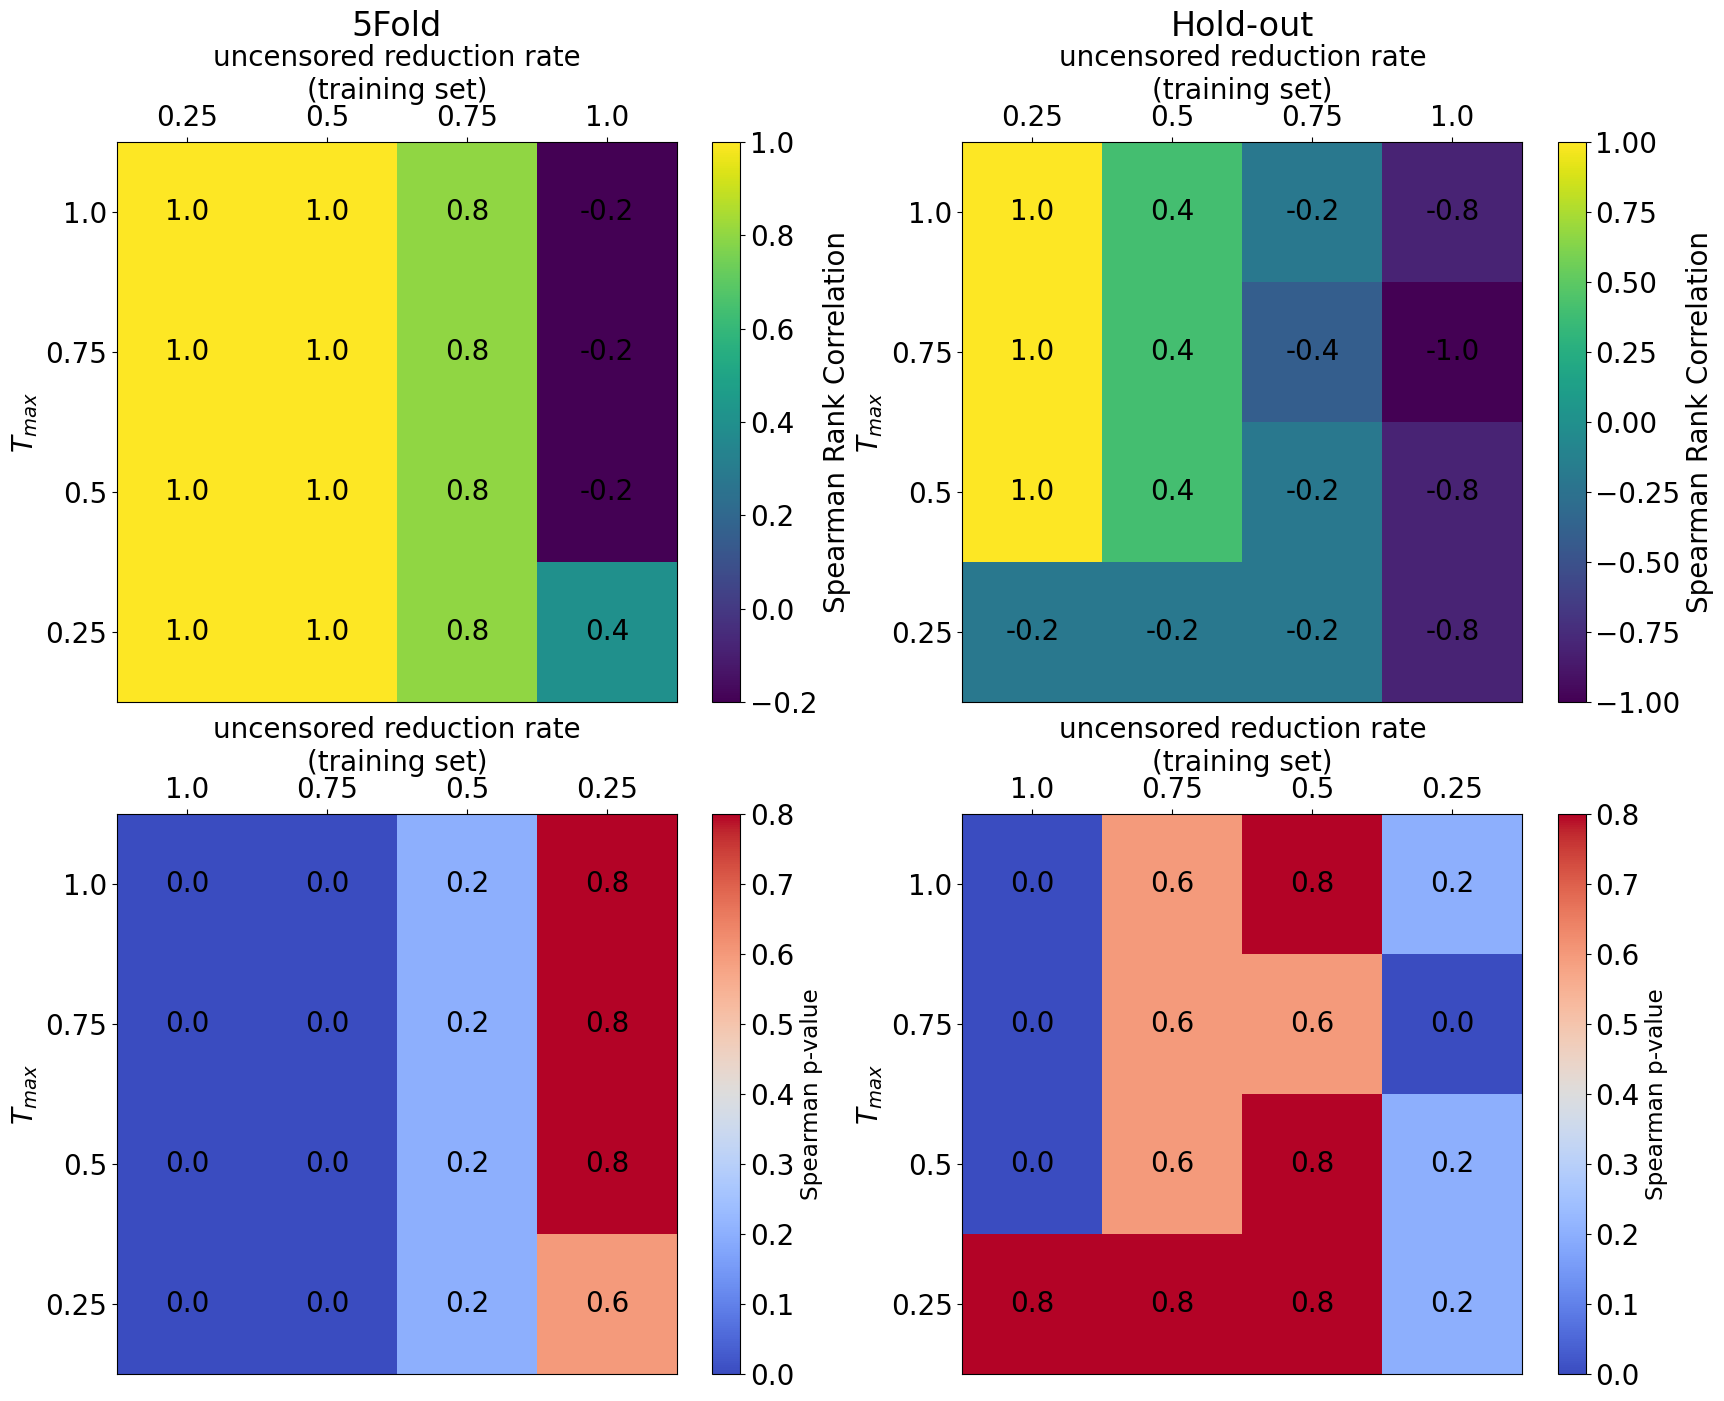

SurvivalTree


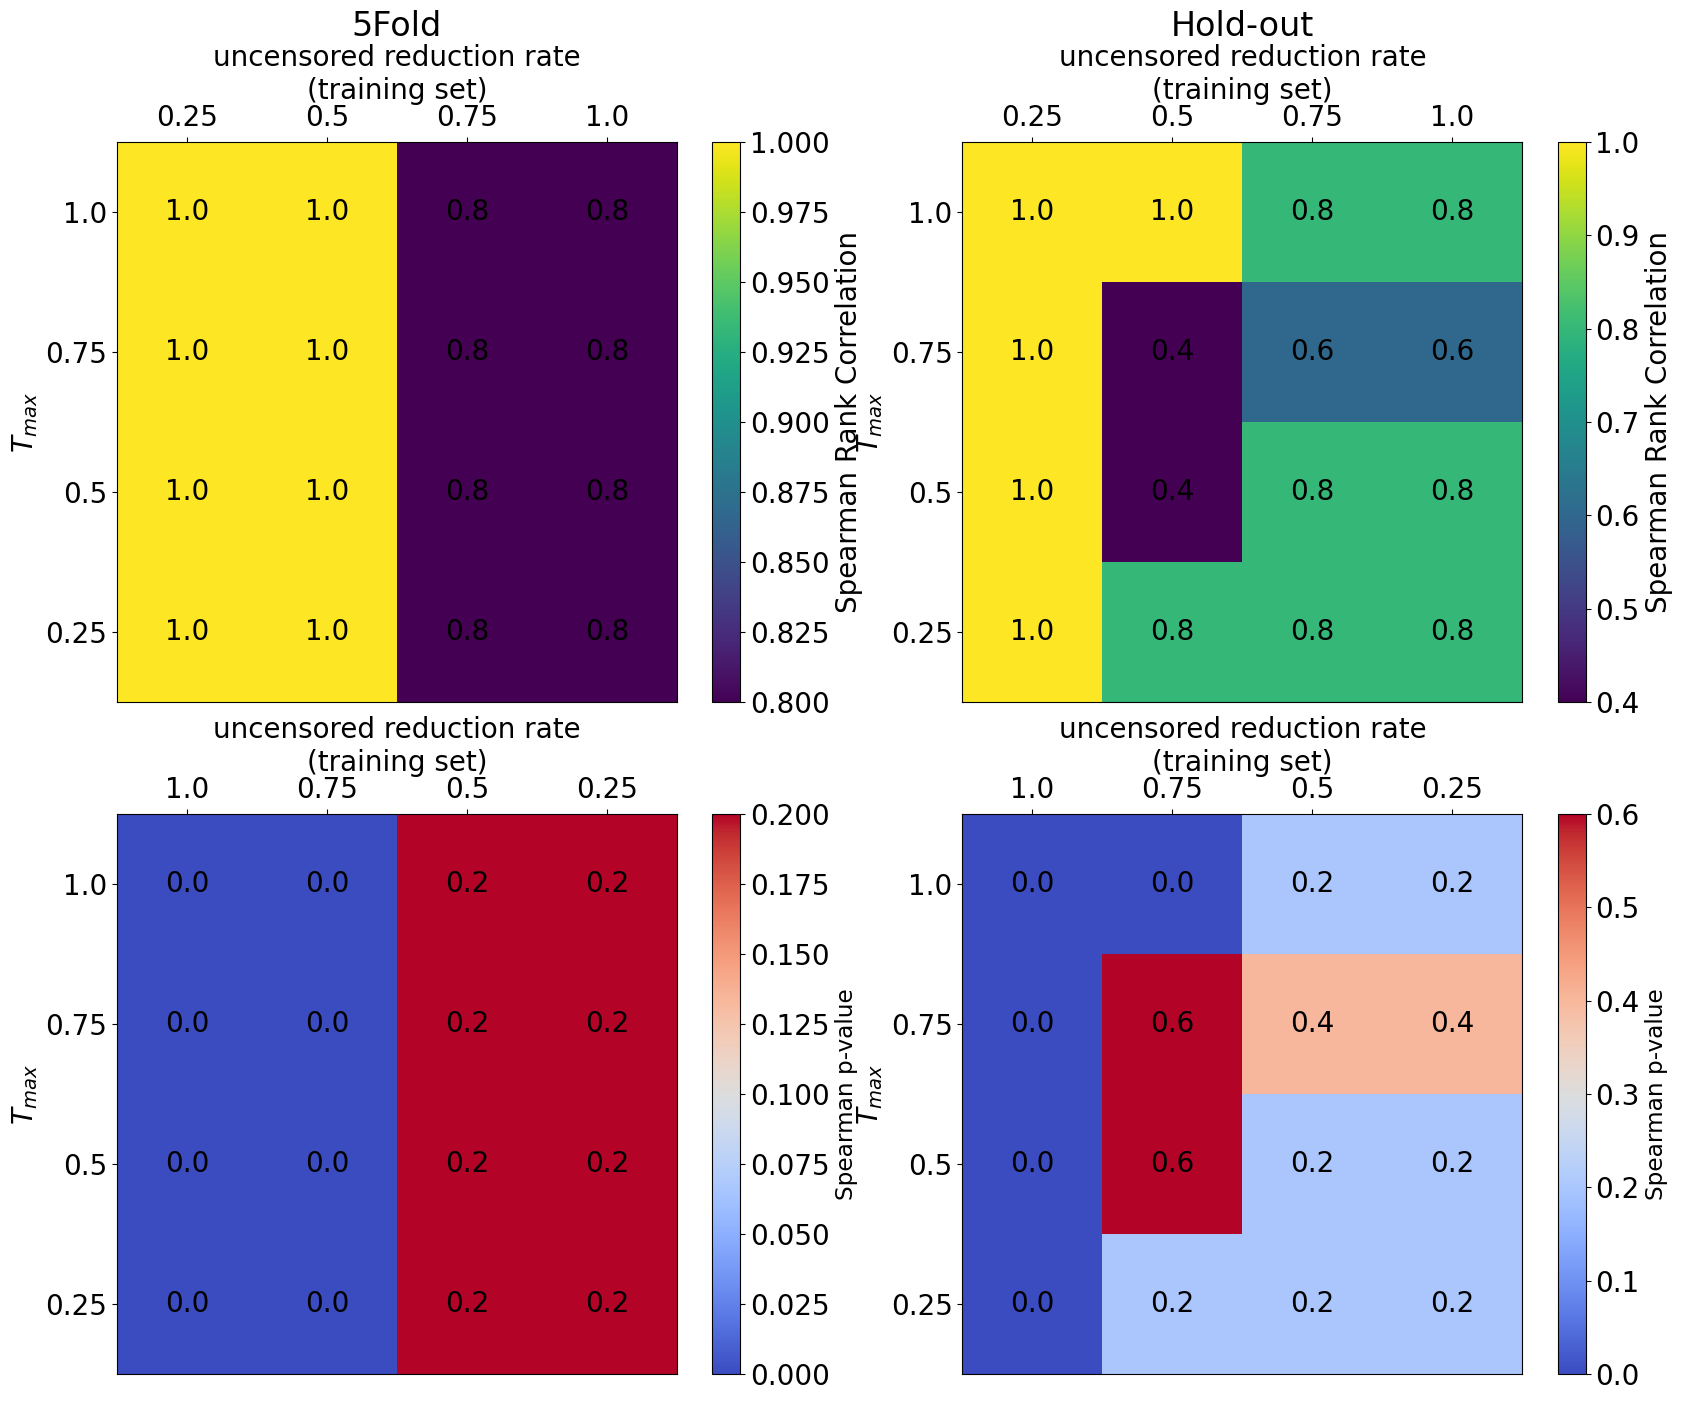

RandomSurvivalForest


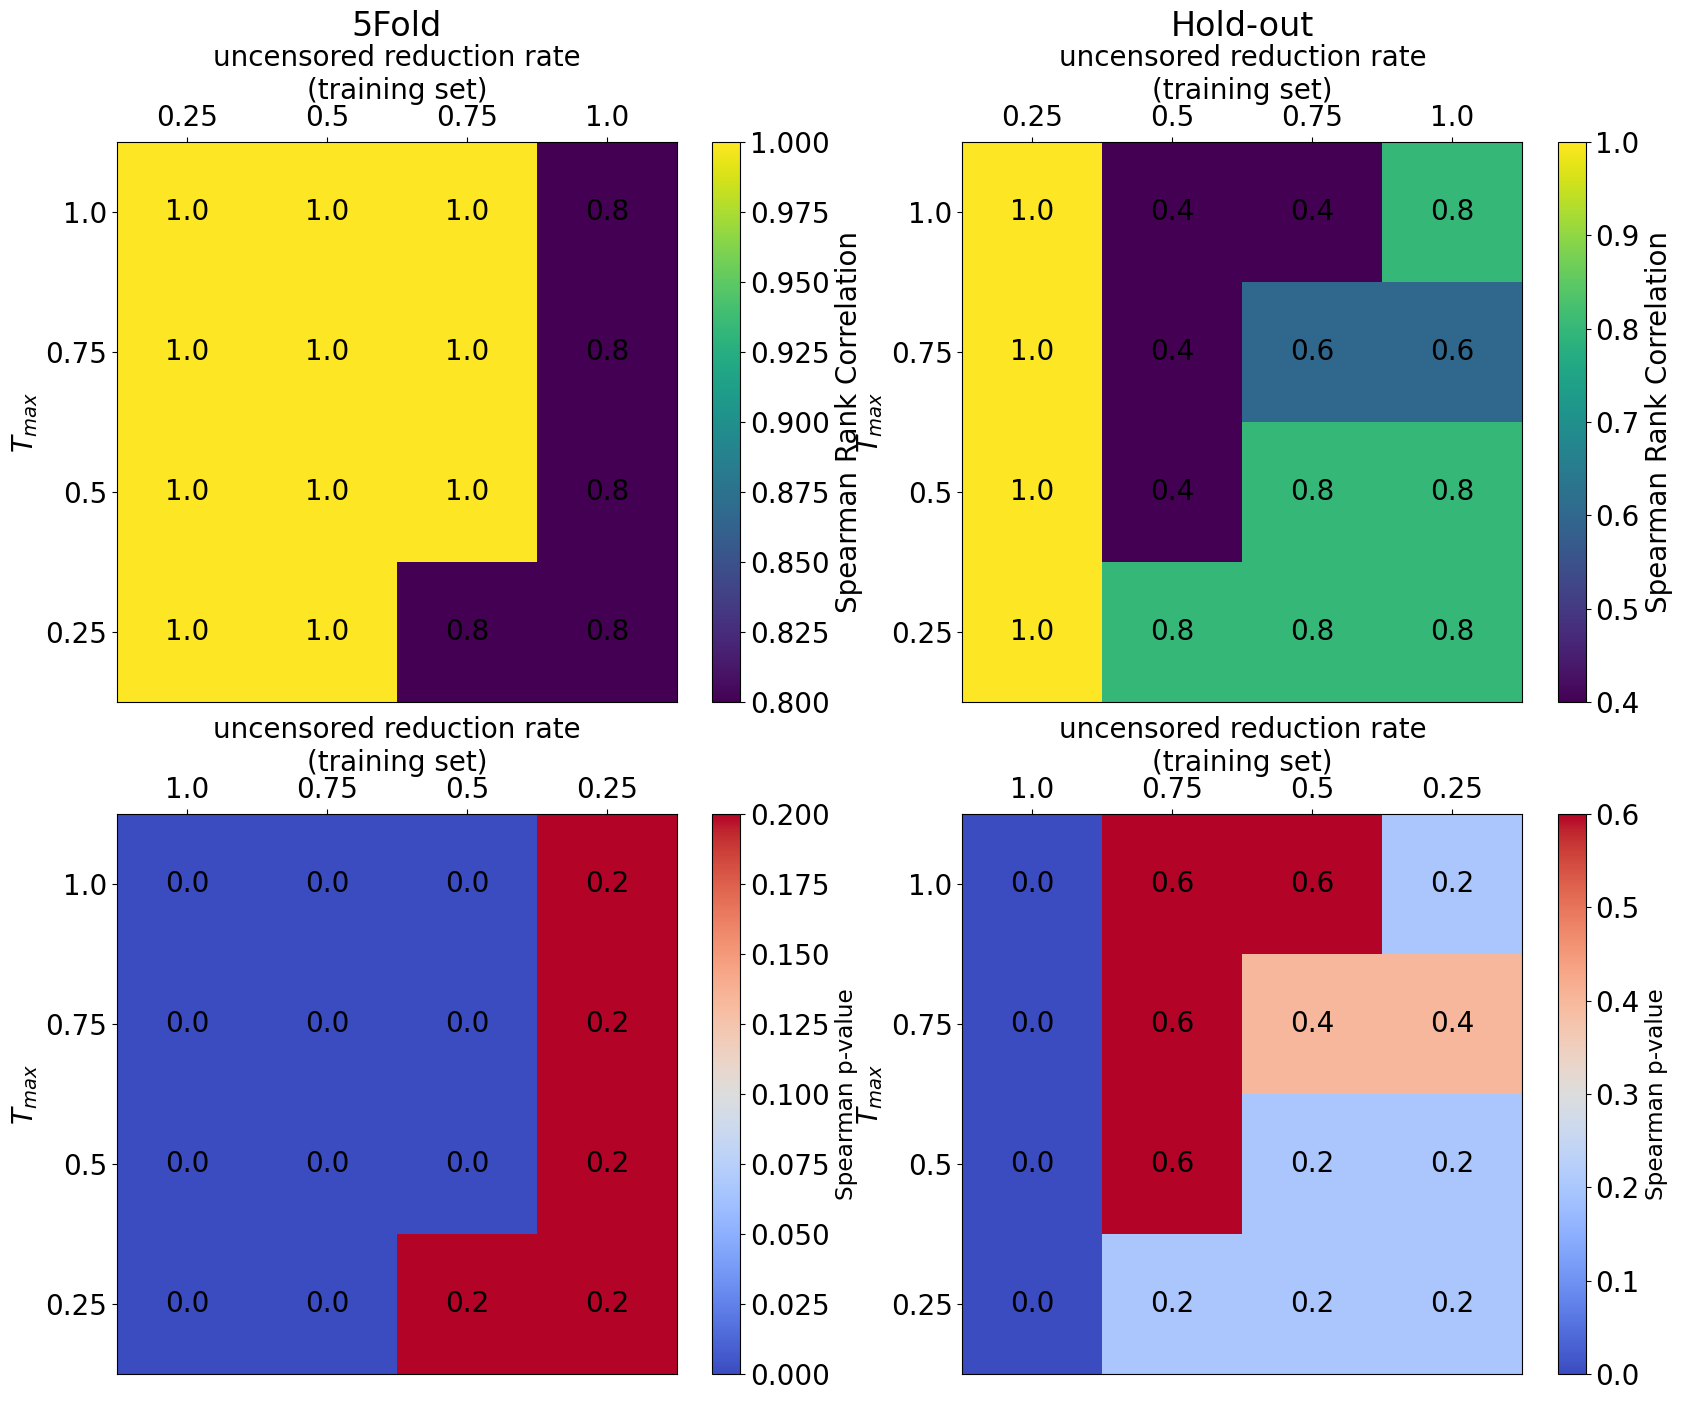

GradientBoosting


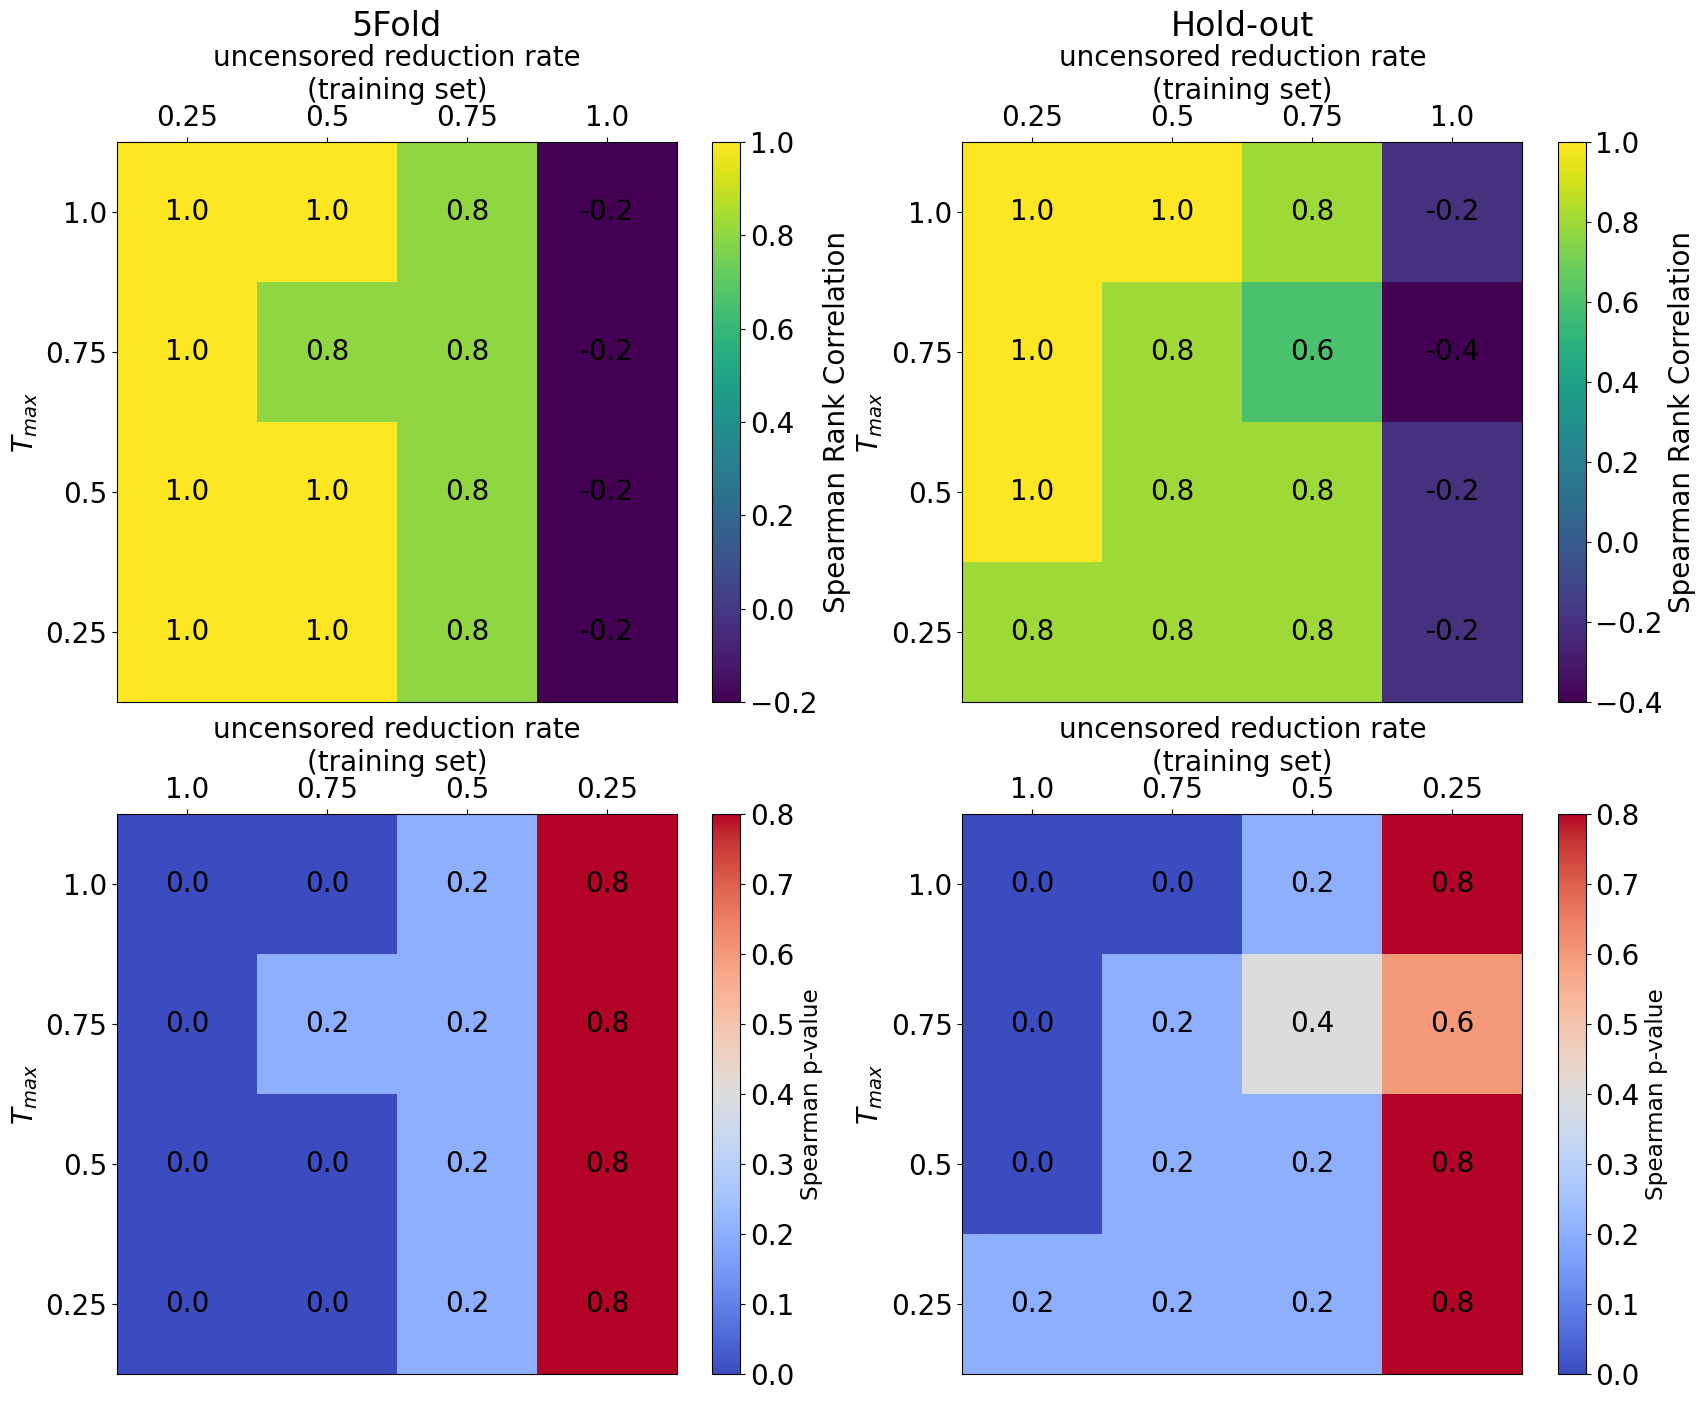

MDN


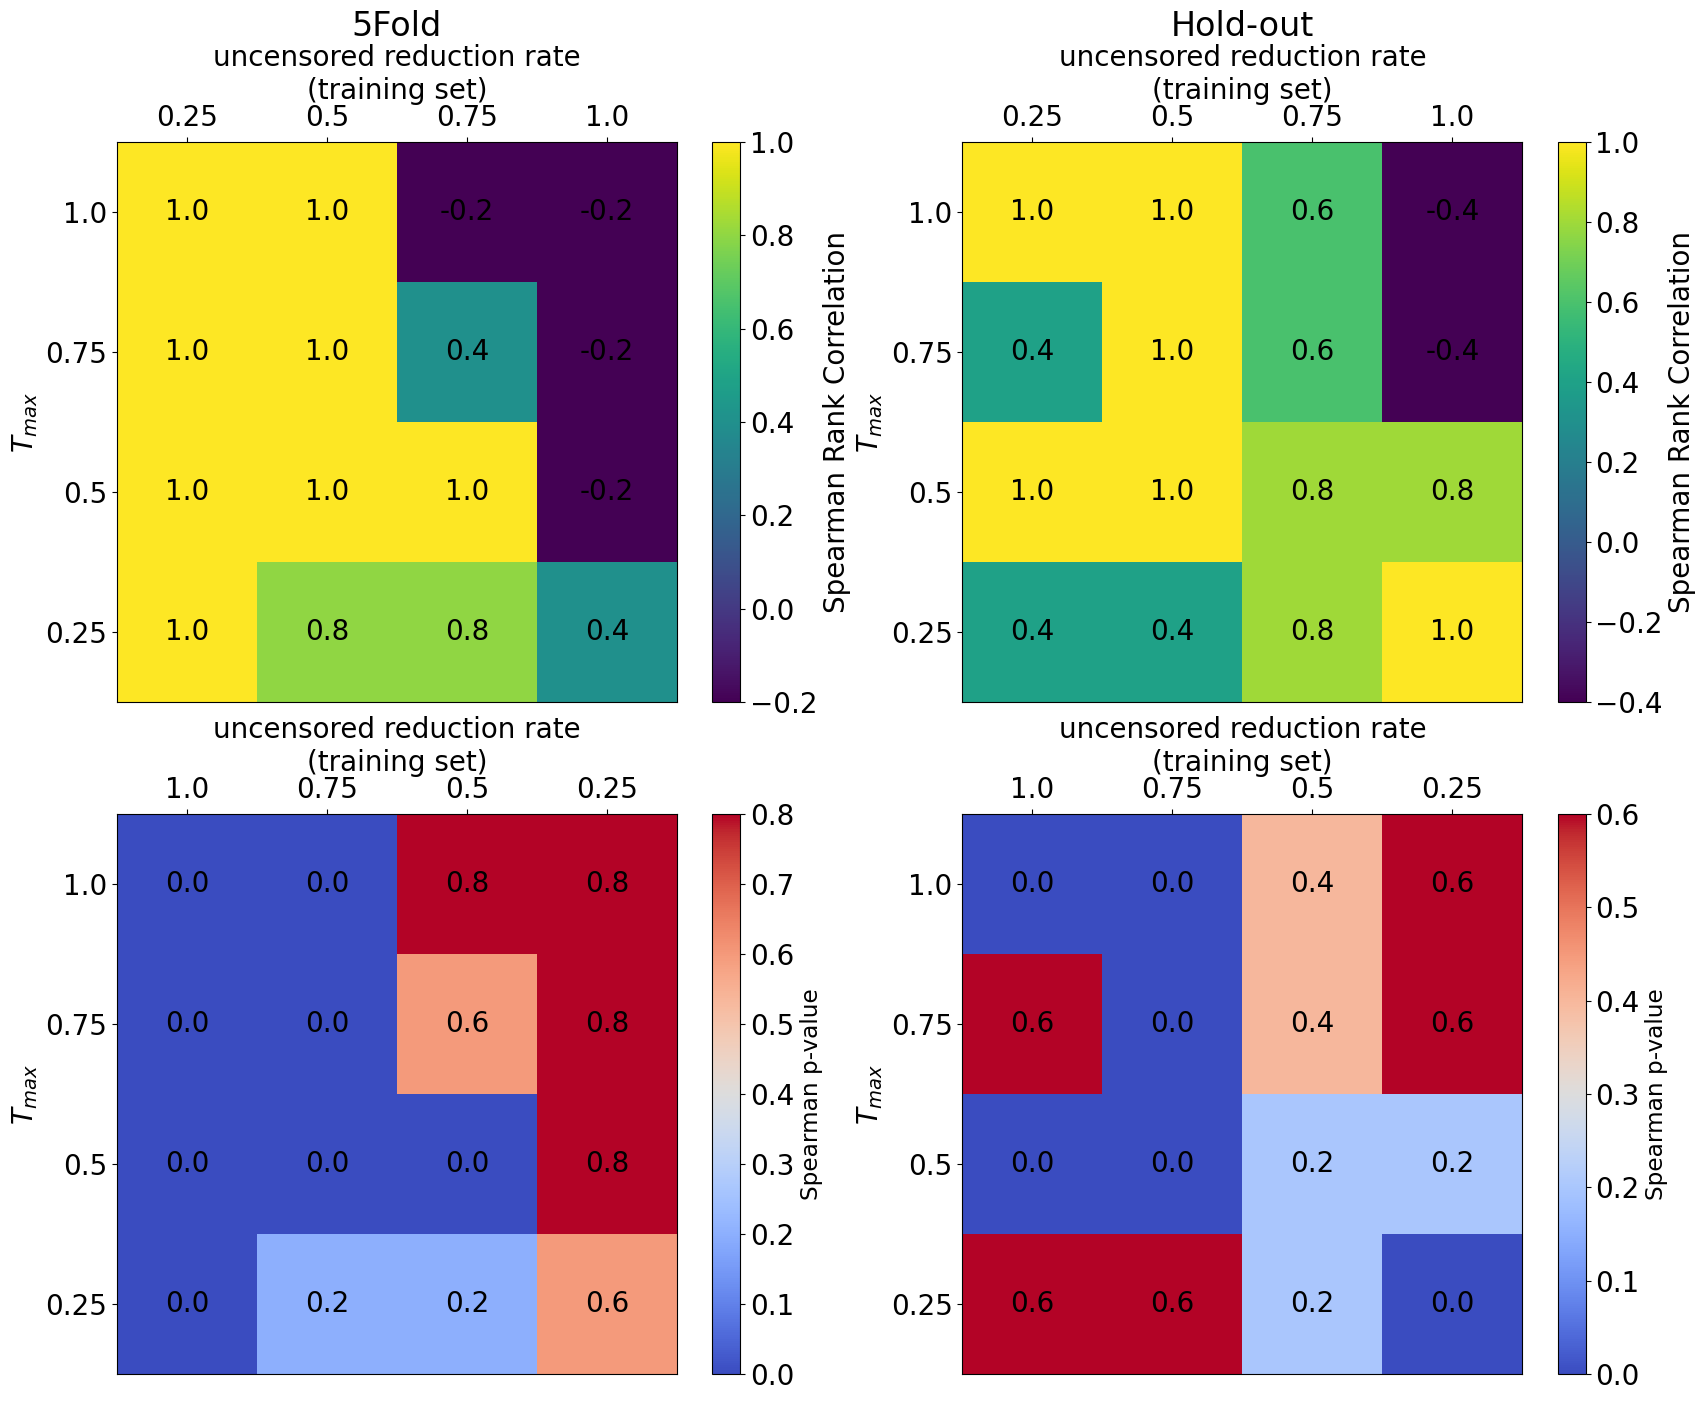

In [347]:
Models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
for model in Models:
    print(model)
    fig, axs = plt.subplots(2,2,figsize=(20,16))
    typs = ["5Fold","Hold-out"]
    locs = [[0,0],[0,1]]
    #ylims = [[0.28,0.85],[-0.7,2.1],[0.5,1.0],[1e-3,1]]

    for typ,loc in zip(typs,locs):
        for _,row in sensitivity_analysis_corr[(sensitivity_analysis_corr.Model == model) & (sensitivity_analysis_corr.Type == typ)].iterrows():
            # Correlation
            # Normalization
            norm = Normalize(vmin = np.array(row.corrs).min(), vmax = np.array(row.corrs).max())
            # Heatmap & Colorbar
            im = axs[loc[0]][loc[1]].imshow(np.array(row.corrs).reshape(4,4), norm = norm)
            cbar = axs[loc[0]][loc[1]].figure.colorbar(im)

            # Ticks & Tick labels
            axs[loc[0]][loc[1]].set_xticks(np.arange(np.array(row.corrs).reshape(4,4).shape[1]), labels=red_rates)
            axs[loc[0]][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]][loc[1]].xaxis.set_ticks_position('top')
            #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
            axs[loc[0]][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]][loc[1]].set_yticks(np.arange(np.array(row.corrs).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman Rank Correlation")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    corr = "{:.5}".format(np.array(row.corrs).reshape(4,4)[i,j])
                    scr_str = f"{corr}"
                    text = axs[loc[0]][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

            # Title
            axs[loc[0]][loc[1]].set_title(typ)

            # p-value
            # Normalization
            norm = Normalize(vmin = np.array(row.pvals).min(), vmax = np.array(row.pvals).max())
            # Heatmap & Colorbar
            im = axs[loc[0]+1][loc[1]].imshow(np.array(row.pvals).reshape(4,4), norm = norm,  cmap = "coolwarm")
            cbar = axs[loc[0]+1][loc[1]].figure.colorbar(im, cmap = "coolwarm")

            # Ticks & Tick labels
            axs[loc[0]+1][loc[1]].set_xticks(np.arange(np.array(row.pvals).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]+1][loc[1]].xaxis.set_ticks_position('top')
            axs[loc[0]+1][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]+1][loc[1]].set_yticks(np.arange(np.array(row.pvals).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman p-value", fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    pval = "{:.5}".format(np.array(row.pvals).reshape(4,4)[i,j])
                    scr_str = f"{pval}"
                    text = axs[loc[0]+1][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

    #fig.tight_layout()
    plt.show()

#### Visualizing the change in dataset quality

In [161]:
from utils import reduce_T_max,reduce_uncensored
from lifelines.fitters.coxph_fitter import CoxPHFitter

y_baseline = y_train.copy()

five_fold_mean = np.zeros((len(T_maxs),len(red_rates))).flatten()
five_fold_std = np.zeros((len(T_maxs),len(red_rates))).flatten()
hold_out_res = np.zeros((len(T_maxs),len(red_rates))).flatten()

i = 0
for T_max,red_rate in sensitivity_grid:
    y_red = np.copy(y_baseline)
    y_red = reduce_T_max(y_red,T_max)

    # 5Fold
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    p_vals = []
    for train_index, test_index in kf.split(y_red):
        y_trn, y_tst = y_red[train_index], y_red[test_index]
        y_trn_baseline, y_tst_baseline = y_baseline[train_index], y_baseline[test_index]
        y_trn = reduce_uncensored(y_trn, red_rate)

        cox_test_df = pd.DataFrame(np.append(np.vstack([y_trn,y_trn_baseline]),np.hstack([np.zeros(len(y_trn)).T,np.ones(len(y_trn_baseline))]).reshape(-1,1),axis=1))

        cph = CoxPHFitter()
        cph.fit(df = cox_test_df,
                duration_col = 0,
                event_col = 1)
        pval = cph.log_likelihood_ratio_test().p_value
        if pval == 0.0:
            pval = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale
        p_vals.append(pval)

    # Hold-out
    y_red = reduce_uncensored(y_red, red_rate)

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_red,y_baseline]),np.hstack([np.zeros(len(y_red)).T,np.ones(len(y_baseline))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    p_val = cph.log_likelihood_ratio_test().p_value
    if p_val == 0.0:
        p_val = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale

    # Adding results to the matrices
    hold_out_res[i] = p_val
    five_fold_mean[i] = np.mean(np.array(p_vals))
    five_fold_std[i] = 1.96*np.std(np.array(p_vals))/np.sqrt(5)

    i += 1

hold_out_res = hold_out_res.reshape((4,4))
five_fold_mean = five_fold_mean.reshape((4,4))
five_fold_std = five_fold_std.reshape((4,4))

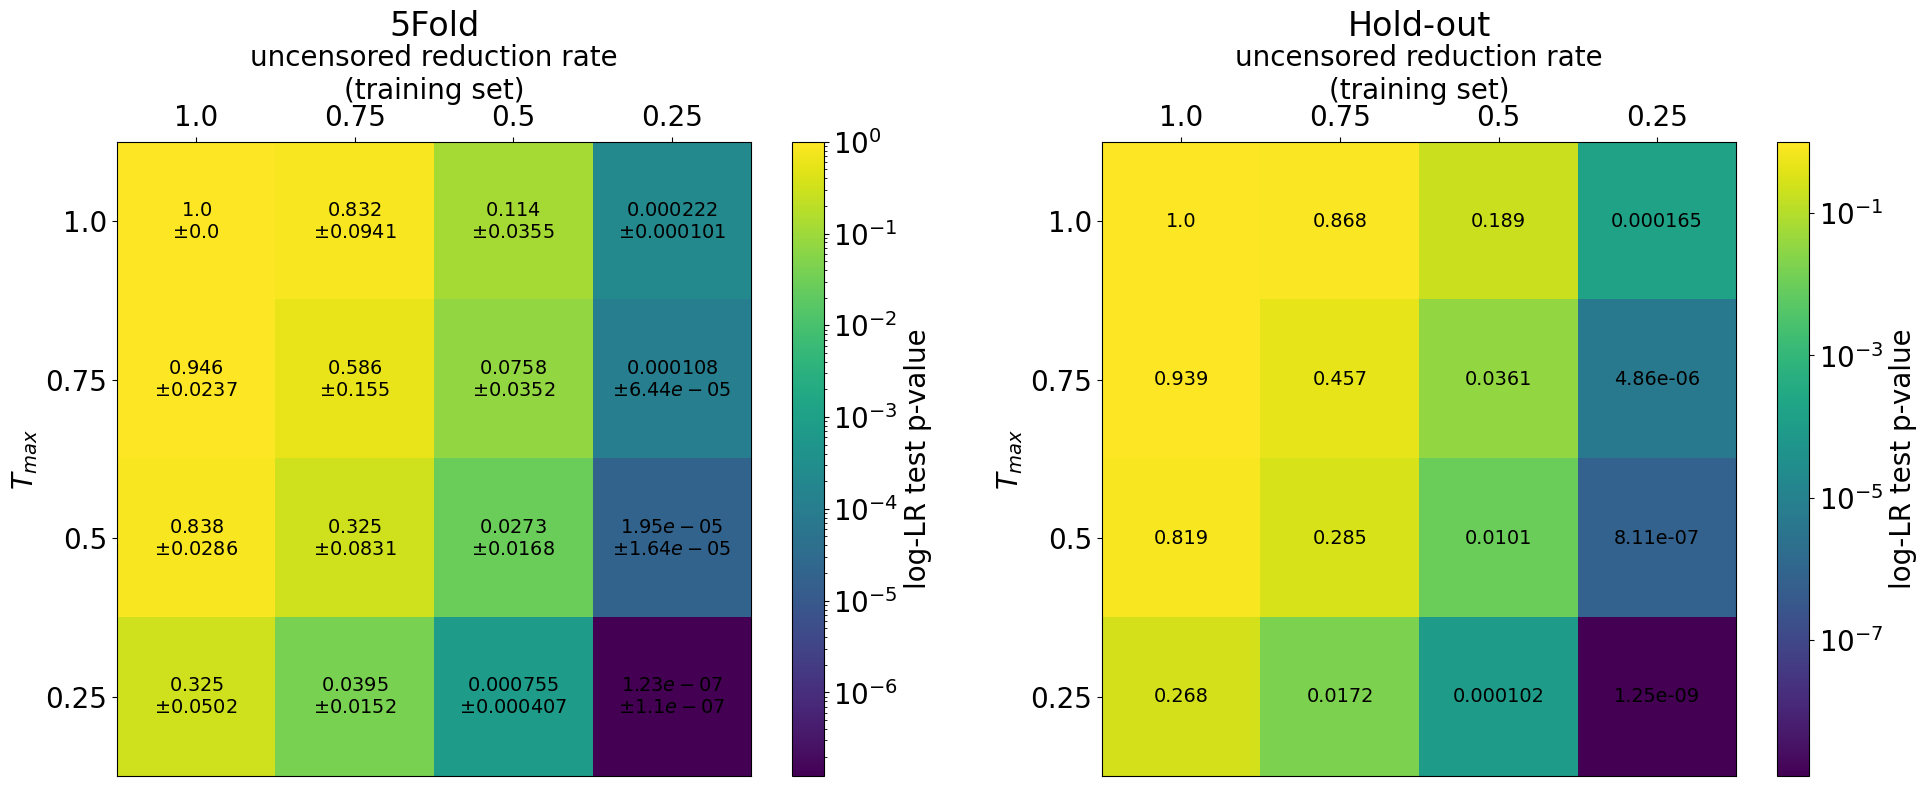

In [345]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
typs = ["5Fold","Hold-out"]
locs = [[0,0],[0,1]]
datas = [five_fold_mean,hold_out_res]

for typ,loc,data in zip(typs,locs,datas):
    # Normalization
    norm = LogNorm(vmin = data.min(), vmax = data.max())

    # Heatmap & Colorbar
    im = axs[loc[1]].imshow(data, norm = norm)
    cbar = axs[loc[1]].figure.colorbar(im)

    # Ticks & Tick labels
    axs[loc[1]].set_xticks(np.arange(data.shape[1]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
    axs[loc[1]].xaxis.set_ticks_position('top')
    #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
    axs[loc[1]].xaxis.set_label_position('top')
    axs[loc[1]].set_yticks(np.arange(data.shape[0]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_ylabel("$T_{max}$")

    # Colorbar labels
    cbar.set_label("log-LR test p-value")

    # Scores as text
    for i in range(len(red_rates)):
        for j in range(len(T_maxs)):
            mean = "{:.3}".format(data[i,j])
            std = "{:.3}".format(five_fold_std[i,j])
            if typ == "5Fold":
                scr_str = f"${mean}$\n$\pm {std}$"
            else:
                scr_str = f"{mean}"
            text = axs[loc[1]].text(j, i, scr_str,ha="center", va="center", size = "x-small")

    # Title
    axs[loc[1]].set_title(typ)

fig.tight_layout()
plt.show()

In [201]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

for _,row in sensitivity_analysis_corr.iterrows():
    print(f"{row.Model}, {row.Type}")
    y_pred = MinMaxScaler().fit_transform(np.array(row.corrs).reshape(-1, 1))
    if row.Type == "5Fold":
        y_true = five_fold_mean.flatten()
        y_true_low = five_fold_mean.flatten() - five_fold_std.flatten()
        y_true_high = five_fold_mean.flatten() + five_fold_std.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        score_low = mean_squared_error(y_true_low, y_pred, squared=False)
        score_high = mean_squared_error(y_true_high, y_pred, squared=False)
        print(f"{score} +/- {score_low-score_high}")
    else:
        y_true = hold_out_res.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        print(score)

CoxPH, 5Fold
0.5446628818124117 +/- 0.058721448323028835
CoxPH, Hold-out
0.23934743020030075
SurvivalTree, 5Fold
0.3607754597227318 +/- 0.06311485030823244
SurvivalTree, Hold-out
0.4960573747369864
RandomSurvivalForest, 5Fold
0.5389512557380264 +/- 0.06264384676148116
RandomSurvivalForest, Hold-out
0.5292242733877446
GradientBoosting, 5Fold
0.5235891585786683 +/- 0.05490048308903517
GradientBoosting, Hold-out
0.5008731090952606
MDN, 5Fold
0.49071794427016746 +/- 0.054699159882268256
MDN, Hold-out
0.5763162828337963


## Degradation

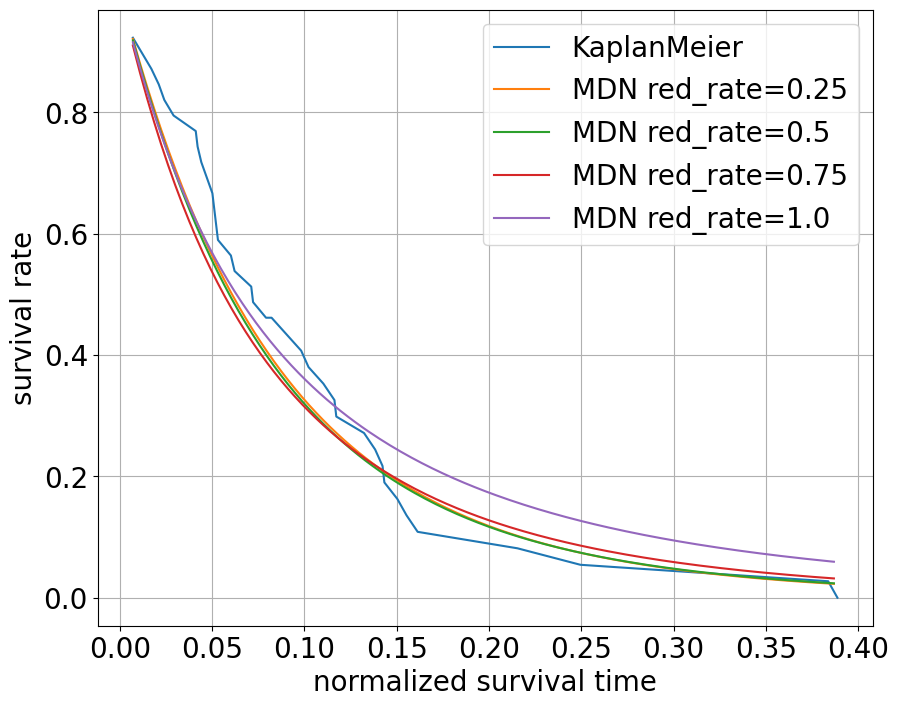

In [202]:
models = ["MDN"]
opts = [True]
red_rates = [0.25,0.5,0.75,1.0]
trials = list(product(models,opts,red_rates))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == trial[2]):
            compare_survival["Model"].append(f"{trial[0]} red_rate={trial[2]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Worsening of survival rate estimate for the population of the {NAME_PLOT} hold-out set\nwith the reduction of uncensored patients in the training set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## All results

In [14]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
trials = list(product(models,opts,T_maxs,red_rates))

master_results  = {"Model":[],
                   "T_max":[],
                   "Uncensored Reduction":[],
                   "5Fold - c-index":[],
                   "5Fold - iBrier":[],
                   "5Fold - AUROC":[],
                   "5Fold - LogRank":[],
                   "Hold-out - c-index":[],
                   "Hold-out - iBrier":[],
                   "Hold-out - AUROC":[],
                   "Hold-out - LogRank":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]) & (results_table["Uncensored_Reduction"][i] == trial[3]):
            master_results["Model"].append(f"{trial[0]} " + ["$_{LogRank}$" if trial[1] == True else ""][0])
            master_results["T_max"].append(results_table["T_max"][i])
            master_results["Uncensored Reduction"].append(results_table["Uncensored_Reduction"][i])
            master_results["5Fold - c-index"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - iBrier"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - AUROC"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - LogRank"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["Hold-out - c-index"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - iBrier"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            master_results["Hold-out - AUROC"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - LogRank"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
master_results = pd.DataFrame.from_dict(master_results)

In [15]:
master_results

Model  T_max  Uncensored Reduction  5Fold - c-index  \
0    CoxPH $_{LogRank}$   1.00                  1.00  0.7064 ± 0.0446   
1    CoxPH $_{LogRank}$   1.00                  0.75  0.6183 ± 0.0698   
2    CoxPH $_{LogRank}$   1.00                  0.50  0.4833 ± 0.1539   
3    CoxPH $_{LogRank}$   1.00                  0.25  0.4991 ± 0.1851   
4    CoxPH $_{LogRank}$   0.75                  1.00  0.7064 ± 0.0446   
..                  ...    ...                   ...              ...   
155                MDN    0.50                  0.25  0.4989 ± 0.1151   
156                MDN    0.25                  1.00  0.7044 ± 0.0467   
157                MDN    0.25                  0.75  0.7017 ± 0.0559   
158                MDN    0.25                  0.50  0.6391 ± 0.0387   
159                MDN    0.25                  0.25  0.6833 ± 0.0403   

      5Fold - iBrier    5Fold - AUROC  5Fold - LogRank Hold-out - c-index  \
0    0.1557 ± 0.0182  0.7869 ± 0.0486  0.3424 ± 0.1618             0.6581   
1    0.2607 ± 0.0713  0.7674 ± 0.0430  0.3646 ± 0.1685             0.6594   
2    0.4519 ± 0.1497  0.7393 ± 0.0720  0.2809 ± 0.2305             0.6306   
3    0.8316 ± 0.1875  0.7576 ± 0.0826  0.0307 ± 0.0506             0.6143   
4    0.1557 ± 0.0182  0.7869 ± 0.0486  0.3424 ± 0.1618             0.6581   
..               ...              ...              ...                ...   
155  0.7993 ± 0.3137  0.6377 ± 0.1100  0.5072 ± 0.1559             0.6472   
156  0.1479 ± 0.0177  0.7980 ± 0.0785  0.6060 ± 0.2134             0.6890   
157  0.2120 ± 0.0267  0.7542 ± 0.0813  0.6085 ± 0.1807             0.6512   
158  0.3230 ± 0.0592  0.6704 ± 0.0358  0.6981 ± 0.1284             0.6359   
159  0.4520 ± 0.1235  0.7183 ± 0.0585  0.6984 ± 0.1099             0.6475   

    Hold-out - iBrier Hold-out - AUROC Hold-out - LogRank  
0              0.1272           0.7164             0.9636  
1              0.1956           0.7491             0.5218  
2              0.5031           0.7327             0.0837  
3              1.6579           0.6805             0.0000  
4              0.1272           0.7164             0.9636  
..                ...              ...                ...  
155            0.5566           0.7042             0.6835  
156            0.1201           0.7550             0.7868  
157            0.1781           0.7220             0.9385  
158            0.2536           0.7182             0.9548  
159            0.3491           0.7442             0.7027  

[160 rows x 11 columns]

In [16]:
# CSV version for the Paper
master_results.to_csv(f"Logs/{NAME}_results.csv",index=False)